# Analyse du Réseau de Transport avec GeoPandas

Ce notebook utilise GeoPandas pour analyser et visualiser le réseau de transport à partir des fichiers GMNS (General Modeling Network Specification) du projet DOTNET.

## 1. Import des bibliothèques nécessaires

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely import wkt
from shapely.geometry import Point, LineString
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Bibliothèques importées avec succès")

✓ Bibliothèques importées avec succès


## 2. Chargement des données géospatiales depuis DOTNET_PROJECT

In [3]:
# Définir les chemins vers les fichiers de données
data_path = '../data/'

# Charger les noeuds
nodes_df = pd.read_csv(data_path + 'node.csv')
print(f"✓ Fichier node.csv chargé: {len(nodes_df)} noeuds")

# Charger les liens
links_df = pd.read_csv(data_path + 'link.csv')
print(f"✓ Fichier link.csv chargé: {len(links_df)} liens")

# Charger la demande
demand_df = pd.read_csv(data_path + 'demand.csv')
print(f"✓ Fichier demand.csv chargé: {len(demand_df)} paires OD")

✓ Fichier node.csv chargé: 8521 noeuds
✓ Fichier link.csv chargé: 30747 liens
✓ Fichier demand.csv chargé: 30422 paires OD


## 3. Exploration et inspection des datasets

In [4]:
# Afficher les premières lignes des noeuds
print("=" * 80)
print("APERÇU DES NOEUDS")
print("=" * 80)
print(nodes_df.head())
print(f"\nColonnes: {list(nodes_df.columns)}")
print(f"\nTypes de données:\n{nodes_df.dtypes}")

APERÇU DES NOEUDS
   node_id  zone_id    x_coord    y_coord  \
0        1      1.0 -87.888534  42.996472   
1        2      2.0 -87.897396  43.004612   
2        3      3.0 -87.941012  42.986585   
3        4      4.0 -87.905384  42.998823   
4        5      5.0 -87.905679  42.992777   

                                        geometry  
0   POINT (-87.88853371142858 42.99647218857143)  
1   POINT (-87.89739580689655 43.00461247356321)  
2             POINT (-87.941011752 42.986585192)  
3         POINT (-87.90538432250001 42.99882289)  
4  POINT (-87.90567903913043 42.992776747826085)  

Colonnes: ['node_id', 'zone_id', 'x_coord', 'y_coord', 'geometry']

Types de données:
node_id       int64
zone_id     float64
x_coord     float64
y_coord     float64
geometry     object
dtype: object


In [5]:
# Afficher les premières lignes des liens
print("=" * 80)
print("APERÇU DES LIENS")
print("=" * 80)
print(links_df.head())
print(f"\nColonnes: {list(links_df.columns)}")
print(f"\nTypes de liens: {links_df['link_type'].unique() if 'link_type' in links_df.columns else 'N/A'}")

APERÇU DES LIENS
   link_id  from_node_id  to_node_id  dir_flag  length  vdf_length_mi  \
0    25311             1        1185         1     0.0            0.0   
1    25578             1        1186         1     0.0            0.0   
2    25313             1        1187         1     0.0            0.0   
3    25580             1        1427         1     0.0            0.0   
4    25582             1        1428         1     0.0            0.0   

   free_speed  vdf_free_speed_mph  vdf_fftt  vdf_toll  link_type  vdf_alpha  \
0          15            9.320568       0.0         0          0        0.5   
1          15            9.320568       0.0         0          0        0.5   
2          15            9.320568       0.0         0          0        0.5   
3          15            9.320568       0.0         0          0        0.5   
4          15            9.320568       0.0         0          0        0.5   

   vdf_beta  vdf_plf  lanes  capacity  ref_volume  obs_volume  \
0   

In [6]:
# Afficher les premières lignes de la demande
print("=" * 80)
print("APERÇU DE LA DEMANDE")
print("=" * 80)
print(demand_df.head(10))
print(f"\nStatistiques de la demande:")
print(demand_df['volume'].describe())

APERÇU DE LA DEMANDE
   o_zone_id  d_zone_id  volume
0          1          2      12
1          1          3       3
2          1          4       5
3          1          5       1
4          1          6       1
5          1          7      11
6          1          8       1
7          1          9       6
8          1         10       3
9          1         12       1

Statistiques de la demande:
count    30422.000000
mean         5.380974
std          9.882363
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        202.000000
Name: volume, dtype: float64


## 4. Préparation des données pour la création du réseau

In [7]:
# Convertir les colonnes geometry WKT en objets géométriques Shapely
print("Conversion des géométries WKT en objets Shapely...")

# Conversion des noeuds
nodes_df['geometry_obj'] = nodes_df['geometry'].apply(wkt.loads)
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry='geometry_obj', crs='EPSG:4326')

# Conversion des liens
links_df['geometry_obj'] = links_df['geometry'].apply(wkt.loads)
links_gdf = gpd.GeoDataFrame(links_df, geometry='geometry_obj', crs='EPSG:4326')

print(f"✓ Noeuds convertis en GeoDataFrame: {len(nodes_gdf)} noeuds")
print(f"✓ Liens convertis en GeoDataFrame: {len(links_gdf)} liens")
print(f"✓ CRS (Coordinate Reference System): {nodes_gdf.crs}")

Conversion des géométries WKT en objets Shapely...
✓ Noeuds convertis en GeoDataFrame: 8521 noeuds
✓ Liens convertis en GeoDataFrame: 30747 liens
✓ CRS (Coordinate Reference System): EPSG:4326


In [8]:
# Vérifier les limites spatiales du réseau
print("=" * 80)
print("LIMITES SPATIALES DU RÉSEAU")
print("=" * 80)
bounds = nodes_gdf.total_bounds
print(f"Min X (longitude): {bounds[0]:.6f}")
print(f"Min Y (latitude): {bounds[1]:.6f}")
print(f"Max X (longitude): {bounds[2]:.6f}")
print(f"Max Y (latitude): {bounds[3]:.6f}")

# Calculer le centroïde du réseau
centroid = nodes_gdf.geometry_obj.unary_union.centroid
print(f"\nCentroïde du réseau: ({centroid.x:.6f}, {centroid.y:.6f})")

LIMITES SPATIALES DU RÉSEAU
Min X (longitude): -88.085376
Min Y (latitude): 42.916169
Max X (longitude): -87.867826
Max Y (latitude): 43.192579

Centroïde du réseau: (-87.962553, 43.056665)


## 5. Création du graphe du réseau à partir des données géospatiales

In [9]:
# Créer un graphe NetworkX à partir des données
print("Création du graphe NetworkX...")

# Créer un graphe dirigé (car dir_flag existe dans les données)
G = nx.DiGraph()

# Ajouter les noeuds avec leurs attributs
for idx, row in nodes_gdf.iterrows():
    G.add_node(
        row['node_id'],
        zone_id=row['zone_id'],
        x=row['x_coord'],
        y=row['y_coord'],
        pos=(row['x_coord'], row['y_coord'])
    )

# Ajouter les liens avec leurs attributs
for idx, row in links_gdf.iterrows():
    G.add_edge(
        row['from_node_id'],
        row['to_node_id'],
        link_id=row['link_id'],
        length=row['length'],
        free_speed=row['free_speed'],
        lanes=row['lanes'],
        capacity=row['capacity'],
        link_type=row['link_type']
    )

print(f"✓ Graphe créé avec {G.number_of_nodes()} noeuds et {G.number_of_edges()} arcs")
print(f"✓ Type de graphe: {'Dirigé' if G.is_directed() else 'Non-dirigé'}")

Création du graphe NetworkX...
✓ Graphe créé avec 8521 noeuds et 30747 arcs
✓ Type de graphe: Dirigé


## 6. Visualisation du réseau

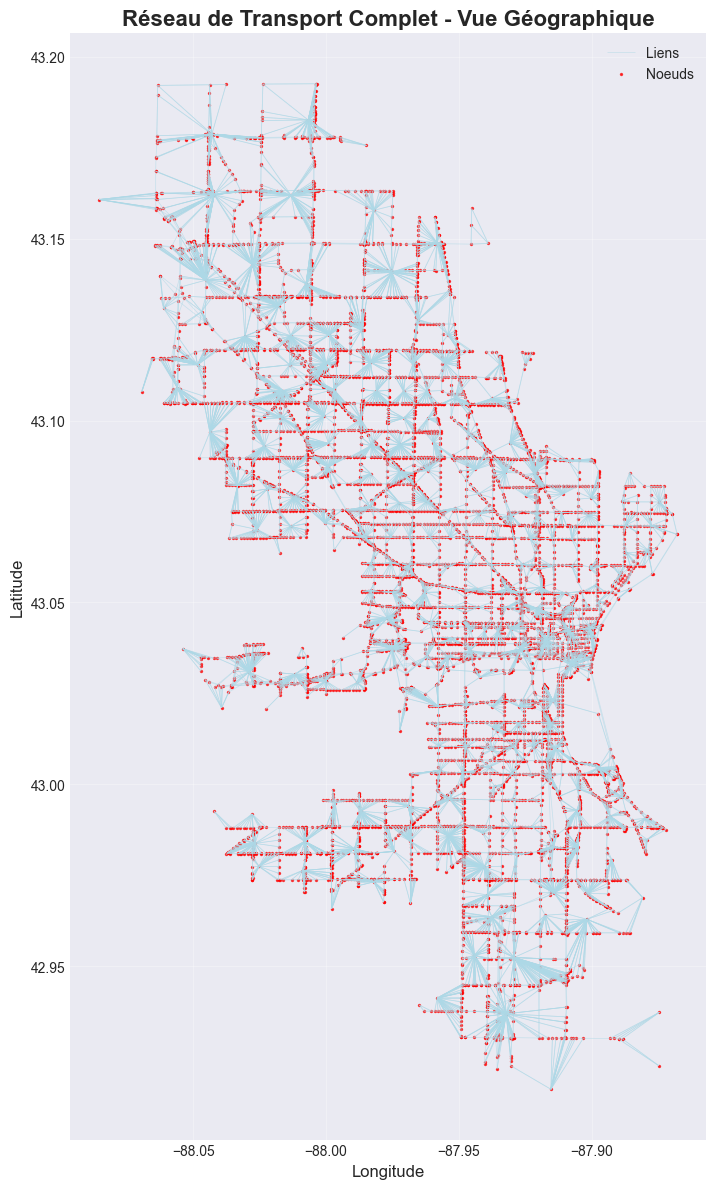

✓ Carte du réseau affichée: 8521 noeuds, 30747 liens


In [10]:
# Visualisation basique du réseau complet
fig, ax = plt.subplots(figsize=(15, 12))

# Dessiner les liens
links_gdf.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.6, label='Liens')

# Dessiner les noeuds
nodes_gdf.plot(ax=ax, color='red', markersize=2, alpha=0.7, label='Noeuds')

plt.title('Réseau de Transport Complet - Vue Géographique', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Carte du réseau affichée: {len(nodes_gdf)} noeuds, {len(links_gdf)} liens")

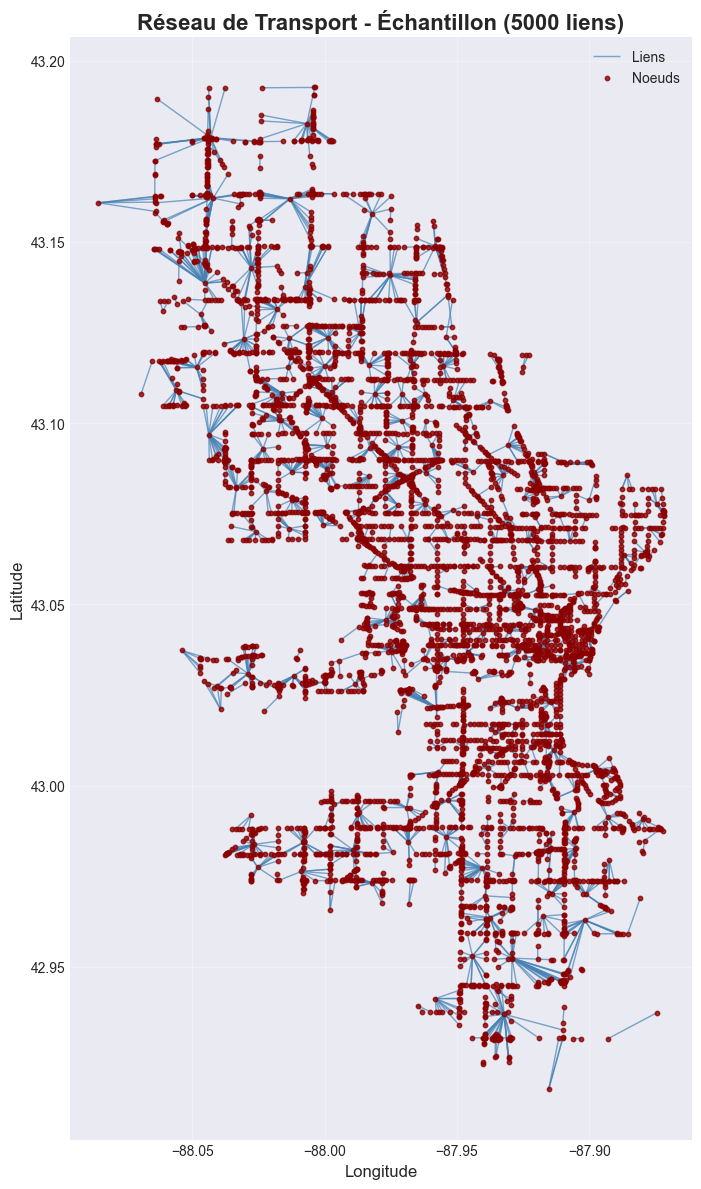

In [11]:
# Visualisation avec zoom sur un sous-ensemble
fig, ax = plt.subplots(figsize=(15, 12))

# Prendre un échantillon pour une vue plus détaillée
sample_size = min(5000, len(links_gdf))
links_sample = links_gdf.sample(n=sample_size, random_state=42)

# Obtenir les noeuds correspondants
node_ids = set(links_sample['from_node_id'].tolist() + links_sample['to_node_id'].tolist())
nodes_sample = nodes_gdf[nodes_gdf['node_id'].isin(node_ids)]

# Dessiner
links_sample.plot(ax=ax, color='steelblue', linewidth=1, alpha=0.7, label='Liens')
nodes_sample.plot(ax=ax, color='darkred', markersize=10, alpha=0.8, label='Noeuds', zorder=5)

plt.title(f'Réseau de Transport - Échantillon ({sample_size} liens)', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

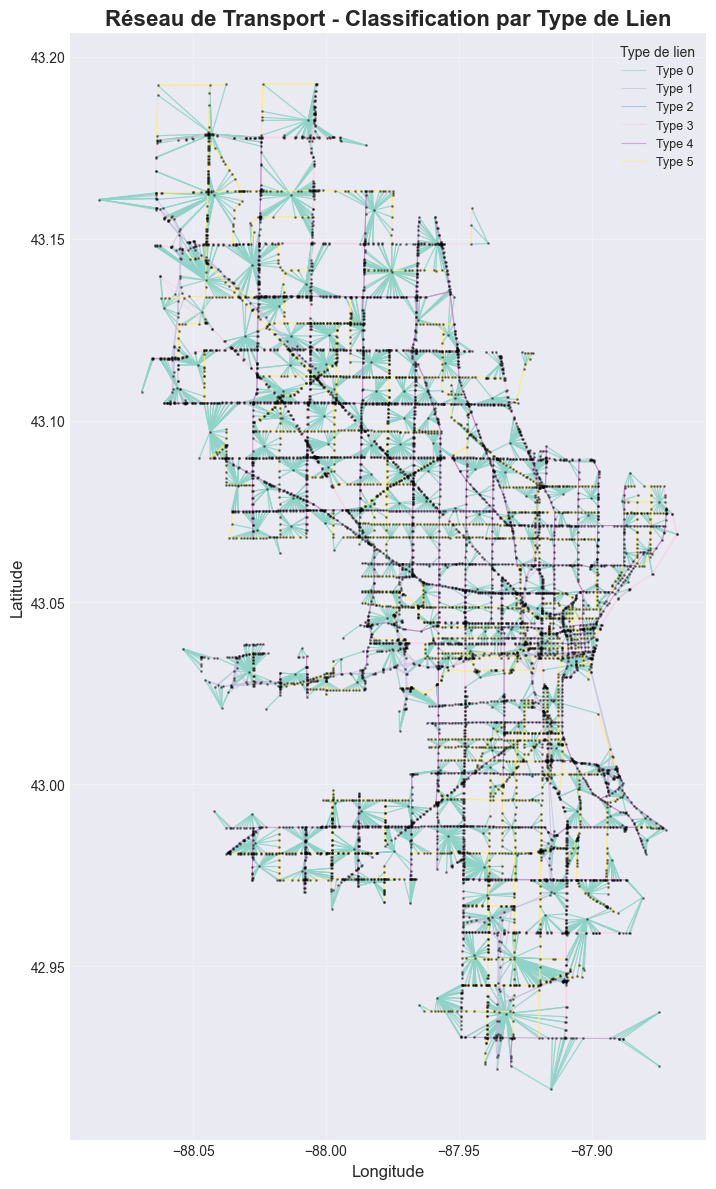

In [12]:
# Visualisation des liens par type
fig, ax = plt.subplots(figsize=(15, 12))

# Grouper les liens par type
link_types = links_gdf['link_type'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(link_types)))

for i, link_type in enumerate(sorted(link_types)):
    subset = links_gdf[links_gdf['link_type'] == link_type]
    subset.plot(ax=ax, color=colors[i], linewidth=0.8, alpha=0.6, label=f'Type {link_type}')

nodes_gdf.plot(ax=ax, color='black', markersize=1, alpha=0.4, zorder=5)

plt.title('Réseau de Transport - Classification par Type de Lien', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Type de lien', fontsize=9, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

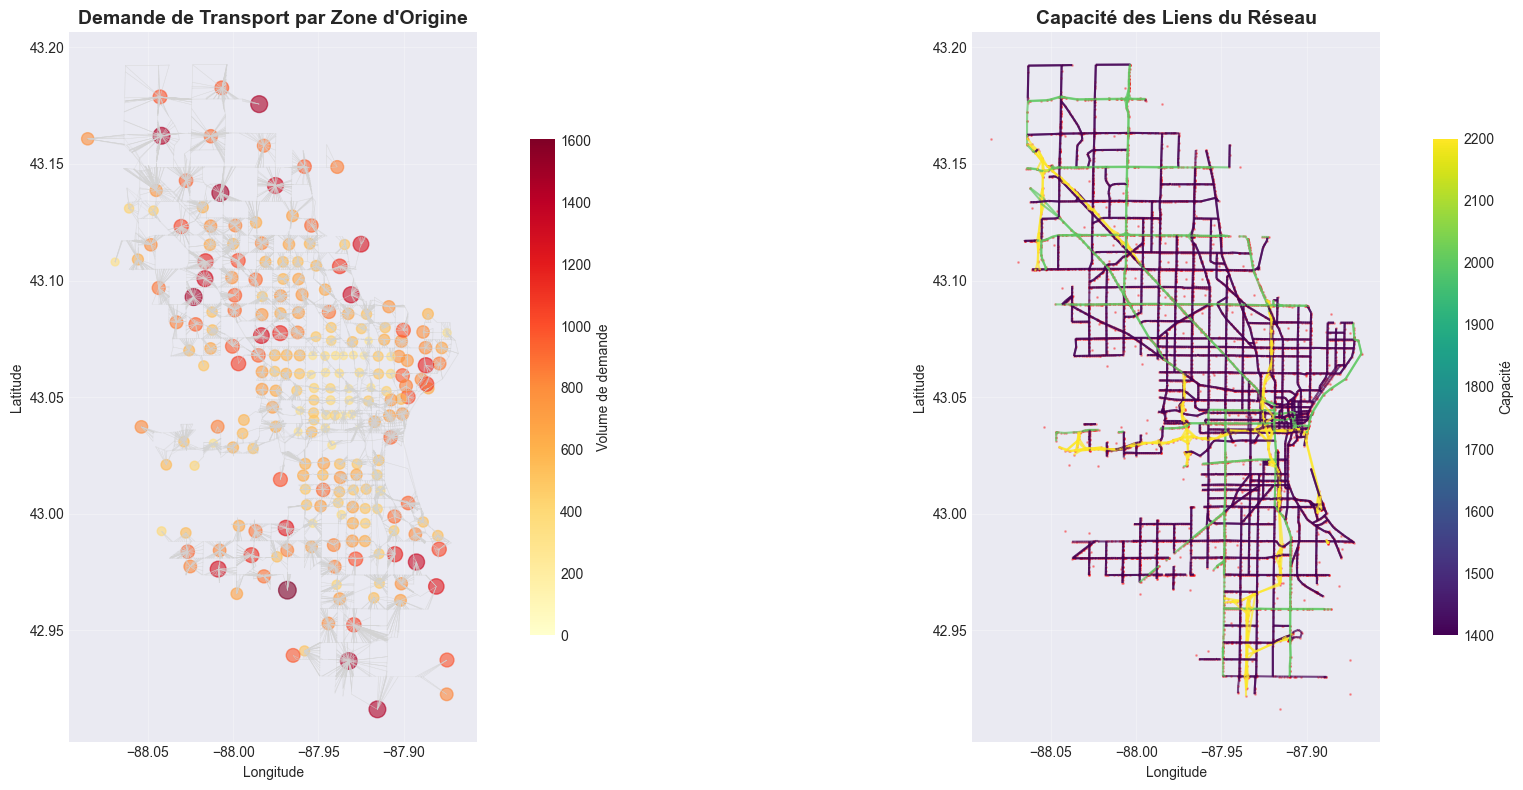

In [13]:
# Visualisation de la densité de la demande
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Agréger la demande par origine
demand_by_origin = demand_df.groupby('o_zone_id')['volume'].sum().reset_index()
demand_by_origin.columns = ['zone_id', 'total_demand']

# Fusionner avec les noeuds
nodes_with_demand = nodes_gdf.merge(demand_by_origin, on='zone_id', how='left')
nodes_with_demand['total_demand'].fillna(0, inplace=True)

# Carte 1: Demande par origine
links_gdf.plot(ax=ax1, color='lightgray', linewidth=0.3, alpha=0.5)
nodes_with_demand.plot(ax=ax1, column='total_demand', cmap='YlOrRd', 
                        markersize=nodes_with_demand['total_demand']/10,
                        alpha=0.6, legend=True, 
                        legend_kwds={'label': 'Volume de demande', 'shrink': 0.7})
ax1.set_title('Demande de Transport par Zone d\'Origine', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True, alpha=0.3)

# Carte 2: Capacité des liens
links_gdf_vis = links_gdf[links_gdf['capacity'] < 99999]  # Exclure les capacités infinies
links_gdf_vis.plot(ax=ax2, column='capacity', cmap='viridis', 
                   linewidth=1.5, alpha=0.7, legend=True,
                   legend_kwds={'label': 'Capacité', 'shrink': 0.7})
nodes_gdf.plot(ax=ax2, color='red', markersize=1, alpha=0.3)
ax2.set_title('Capacité des Liens du Réseau', fontsize=14, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

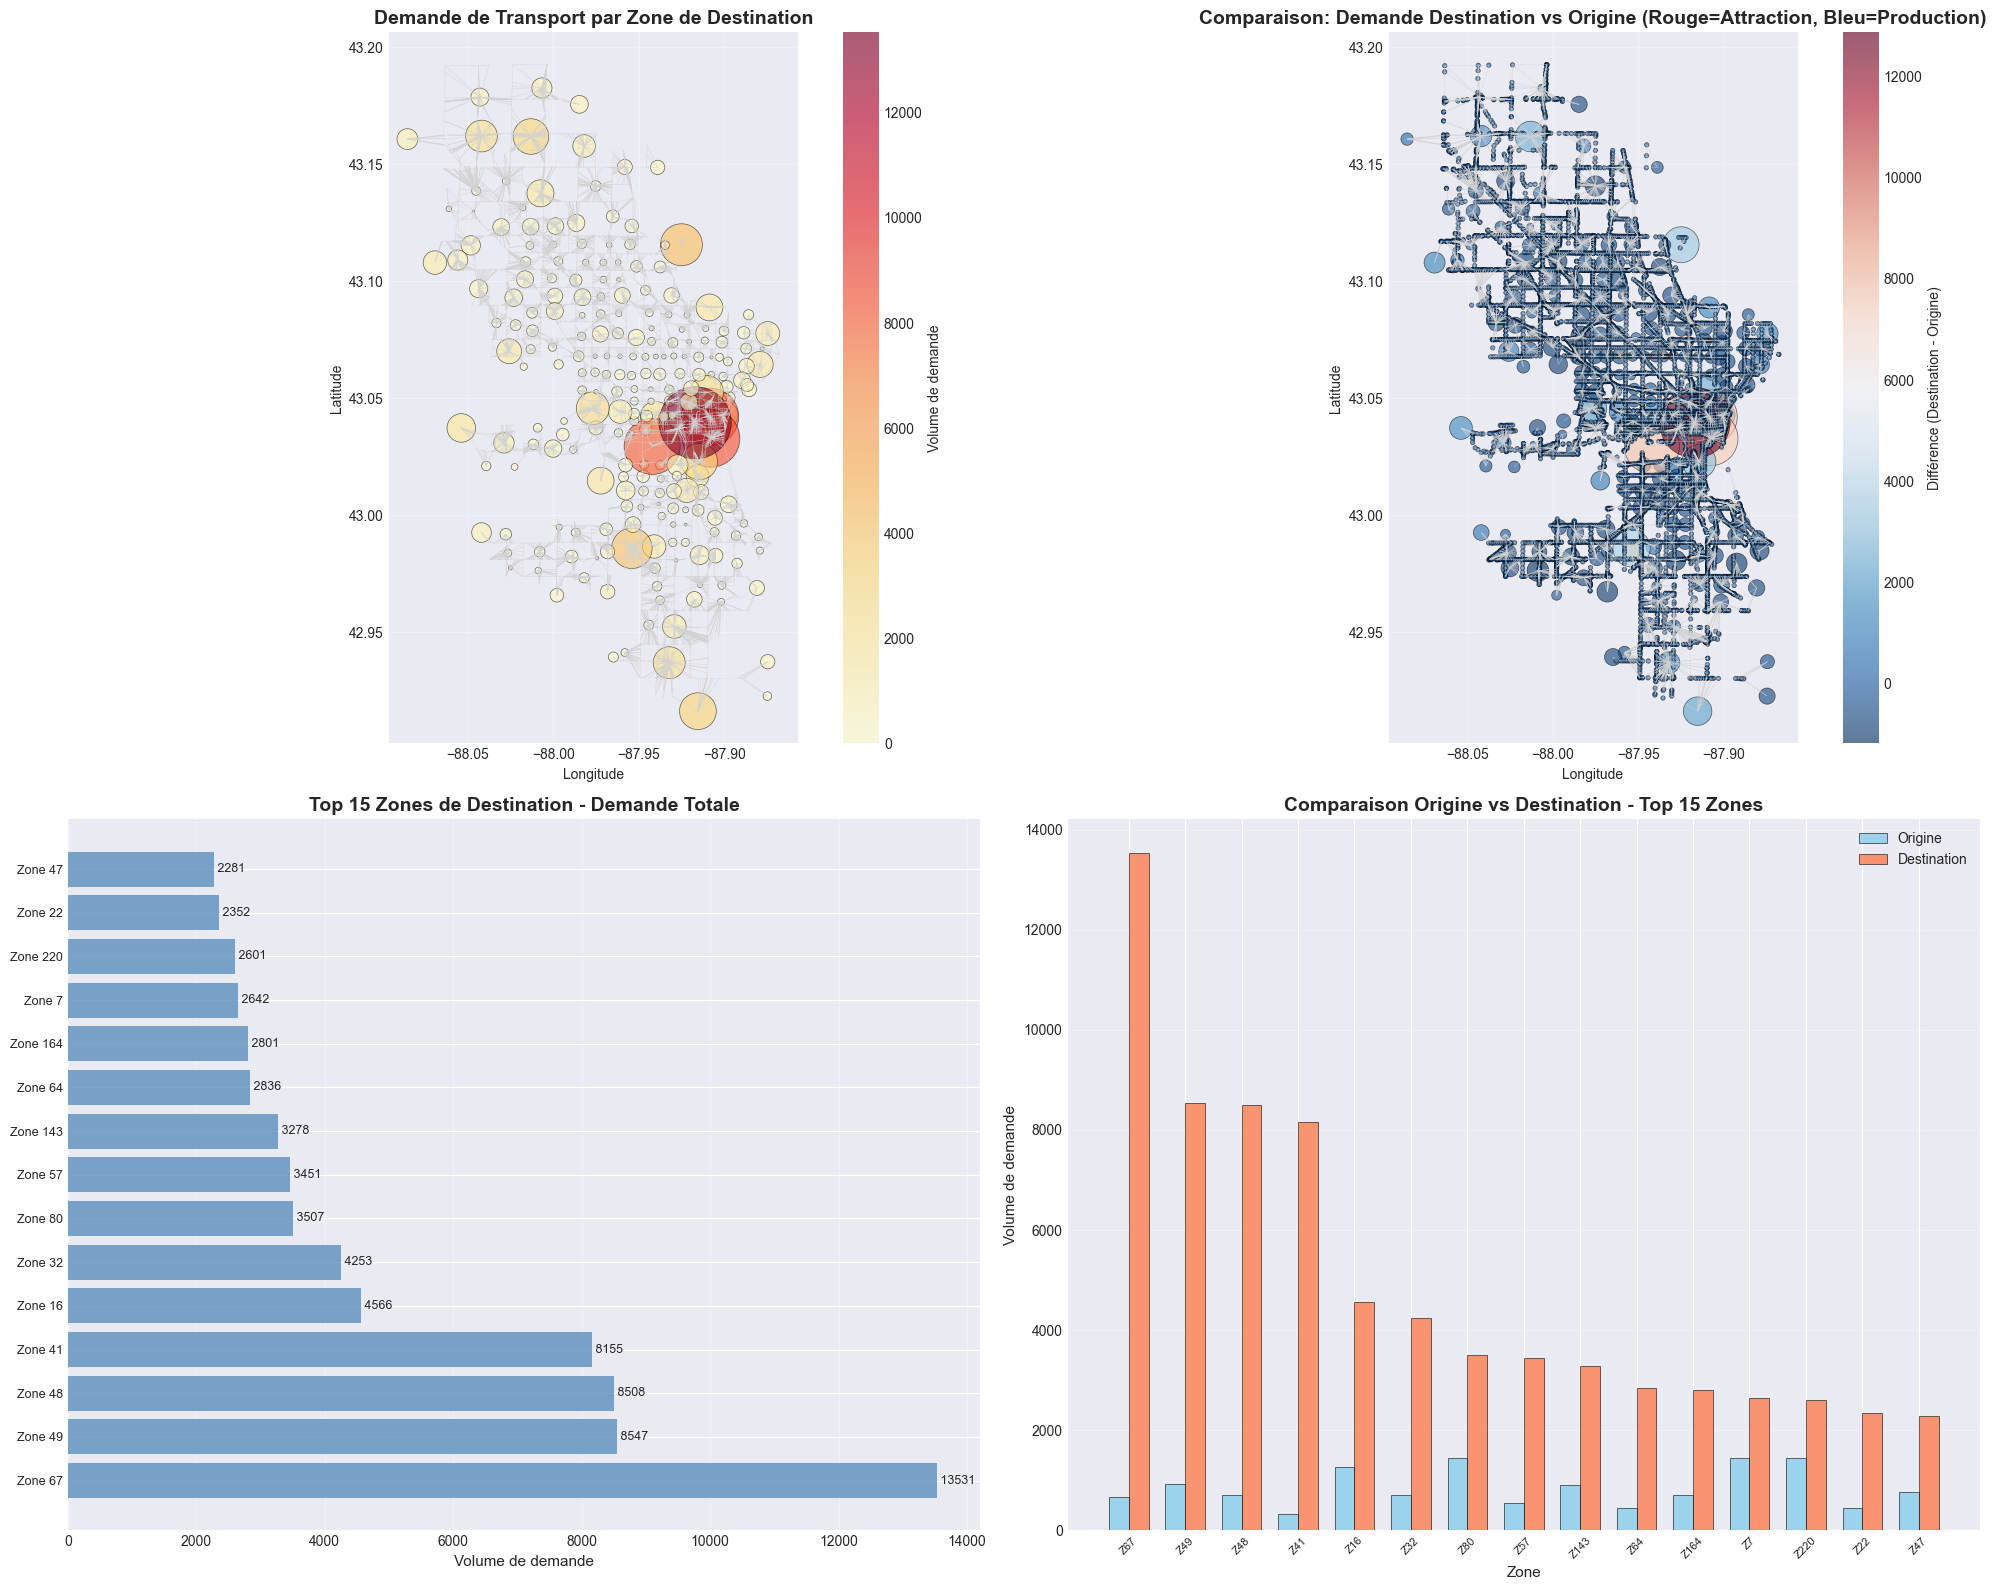

✓ Visualisations de la demande par destination affichées


In [14]:
# Visualisation de la demande par zone d'arrivée (destination)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Agréger la demande par destination
demand_by_dest = demand_df.groupby('d_zone_id')['volume'].sum().reset_index()
demand_by_dest.columns = ['zone_id', 'total_demand']

# Fusionner avec les noeuds
nodes_with_dest_demand = nodes_gdf.merge(demand_by_dest, on='zone_id', how='left')
nodes_with_dest_demand['total_demand'].fillna(0, inplace=True)

# Carte 1: Demande totale par destination
links_gdf.plot(ax=axes[0, 0], color='lightgray', linewidth=0.3, alpha=0.5)
scatter1 = axes[0, 0].scatter(nodes_with_dest_demand.geometry_obj.x, 
                               nodes_with_dest_demand.geometry_obj.y,
                               c=nodes_with_dest_demand['total_demand'], 
                               cmap='YlOrRd', s=nodes_with_dest_demand['total_demand']/5,
                               alpha=0.6, edgecolors='black', linewidth=0.5)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
cbar1.set_label('Volume de demande', fontsize=10)
axes[0, 0].set_title('Demande de Transport par Zone de Destination', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Longitude')
axes[0, 0].set_ylabel('Latitude')
axes[0, 0].grid(True, alpha=0.3)

# Carte 2: Comparaison Origine vs Destination
demand_by_origin_2 = demand_df.groupby('o_zone_id')['volume'].sum().reset_index()
demand_by_origin_2.columns = ['zone_id', 'origin_demand']
nodes_comparison = nodes_gdf.merge(demand_by_origin_2, on='zone_id', how='left')
nodes_comparison = nodes_comparison.merge(demand_by_dest, on='zone_id', how='left')
nodes_comparison['origin_demand'].fillna(0, inplace=True)
nodes_comparison['total_demand'].fillna(0, inplace=True)
nodes_comparison['diff_demand'] = nodes_comparison['total_demand'] - nodes_comparison['origin_demand']

links_gdf.plot(ax=axes[0, 1], color='lightgray', linewidth=0.3, alpha=0.5)
scatter2 = axes[0, 1].scatter(nodes_comparison.geometry_obj.x, 
                               nodes_comparison.geometry_obj.y,
                               c=nodes_comparison['diff_demand'], 
                               cmap='RdBu_r', s=np.abs(nodes_comparison['diff_demand'])/5 + 10,
                               alpha=0.6, edgecolors='black', linewidth=0.5)
cbar2 = plt.colorbar(scatter2, ax=axes[0, 1])
cbar2.set_label('Différence (Destination - Origine)', fontsize=10)
axes[0, 1].set_title('Comparaison: Demande Destination vs Origine (Rouge=Attraction, Bleu=Production)', 
                     fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_ylabel('Latitude')
axes[0, 1].grid(True, alpha=0.3)

# Graphique 3: Distribution de la demande par destination
top_destinations = demand_by_dest.nlargest(15, 'total_demand')
axes[1, 0].barh(range(len(top_destinations)), top_destinations['total_demand'].values, color='steelblue', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_destinations)))
axes[1, 0].set_yticklabels([f"Zone {int(z)}" for z in top_destinations['zone_id'].values], fontsize=9)
axes[1, 0].set_xlabel('Volume de demande', fontsize=11)
axes[1, 0].set_title('Top 15 Zones de Destination - Demande Totale', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(top_destinations['total_demand'].values):
    axes[1, 0].text(v, i, f" {int(v)}", va='center', fontsize=9)

# Graphique 4: Comparaison Origine vs Destination pour les top 15 destinations
top_dest_zones = demand_by_dest.nlargest(15, 'total_demand')['zone_id'].values
comparison_data = pd.DataFrame({
    'zone_id': top_dest_zones,
})
comparison_data = comparison_data.merge(demand_by_origin_2.rename(columns={'origin_demand': 'Origine'}), 
                                        on='zone_id', how='left')
comparison_data = comparison_data.merge(demand_by_dest.rename(columns={'total_demand': 'Destination'}), 
                                        on='zone_id', how='left')
comparison_data.fillna(0, inplace=True)

x_pos = np.arange(len(comparison_data))
width = 0.35
axes[1, 1].bar(x_pos - width/2, comparison_data['Origine'].values, width, label='Origine', 
               color='skyblue', alpha=0.8, edgecolor='black', linewidth=0.5)
axes[1, 1].bar(x_pos + width/2, comparison_data['Destination'].values, width, label='Destination', 
               color='coral', alpha=0.8, edgecolor='black', linewidth=0.5)
axes[1, 1].set_xlabel('Zone', fontsize=11)
axes[1, 1].set_ylabel('Volume de demande', fontsize=11)
axes[1, 1].set_title('Comparaison Origine vs Destination - Top 15 Zones', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f"Z{int(z)}" for z in comparison_data['zone_id'].values], fontsize=8, rotation=45)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Visualisations de la demande par destination affichées")

In [15]:
# Statistiques détaillées sur la demande par zone d'arrivée
print("=" * 80)
print("STATISTIQUES DÉTAILLÉES - DEMANDE PAR ZONE DE DESTINATION")
print("=" * 80)

demand_by_origin_stats = demand_df.groupby('o_zone_id')['volume'].sum().reset_index()
demand_by_origin_stats.columns = ['zone_id', 'volume']
demand_by_dest_stats = demand_df.groupby('d_zone_id')['volume'].sum().reset_index()
demand_by_dest_stats.columns = ['zone_id', 'volume']

print(f"\nDemande agrégée par destination (top 20):")
print(demand_by_dest_stats.nlargest(20, 'volume').to_string(index=False))

print(f"\n\nStatistiques de la demande par destination:")
print(f"  - Demande totale par destination: {demand_by_dest_stats['volume'].sum():.0f}")
print(f"  - Demande moyenne par destination: {demand_by_dest_stats['volume'].mean():.2f}")
print(f"  - Demande max: {demand_by_dest_stats['volume'].max():.0f}")
print(f"  - Demande min: {demand_by_dest_stats['volume'].min():.0f}")
print(f"  - Écart-type: {demand_by_dest_stats['volume'].std():.2f}")

# Comparer avec l'origine
print(f"\n\nComparaison Origine vs Destination:")
print(f"  - Zones productrices (origine): {len(demand_by_origin_stats)}")
print(f"  - Zones attractrices (destination): {len(demand_by_dest_stats)}")

# Identifier les zones fortement attractrices
print(f"\n\nZones fortement attractrices (top 10 destinations):")
top_10_dest = demand_by_dest_stats.nlargest(10, 'volume')
for idx, row in top_10_dest.iterrows():
    pct = (row['volume'] / demand_by_dest_stats['volume'].sum()) * 100
    print(f"  Zone {int(row['zone_id'])}: {row['volume']:.0f} ({pct:.2f}%)")

STATISTIQUES DÉTAILLÉES - DEMANDE PAR ZONE DE DESTINATION

Demande agrégée par destination (top 20):
 zone_id  volume
      67   13531
      49    8547
      48    8508
      41    8155
      16    4566
      32    4253
      80    3507
      57    3451
     143    3278
      64    2836
     164    2801
       7    2642
     220    2601
      22    2352
      47    2281
     137    2110
      40    1930
     145    1882
     135    1865
     113    1857


Statistiques de la demande par destination:
  - Demande totale par destination: 163700
  - Demande moyenne par destination: 699.57
  - Demande max: 13531
  - Demande min: 12
  - Écart-type: 1420.60


Comparaison Origine vs Destination:
  - Zones productrices (origine): 234
  - Zones attractrices (destination): 234


Zones fortement attractrices (top 10 destinations):
  Zone 67: 13531 (8.27%)
  Zone 49: 8547 (5.22%)
  Zone 48: 8508 (5.20%)
  Zone 41: 8155 (4.98%)
  Zone 16: 4566 (2.79%)
  Zone 32: 4253 (2.60%)
  Zone 80: 3507 (2.14%)
 

## 7. Calcul des métriques du réseau

In [16]:
# Statistiques de base du réseau
print("=" * 80)
print("STATISTIQUES DU RÉSEAU")
print("=" * 80)
print(f"Nombre de noeuds: {G.number_of_nodes()}")
print(f"Nombre d'arcs: {G.number_of_edges()}")
print(f"Densité du réseau: {nx.density(G):.6f}")
print(f"Réseau connecté: {nx.is_strongly_connected(G)}")

# Nombre de composantes connectées
n_components = nx.number_strongly_connected_components(G)
print(f"Nombre de composantes fortement connectées: {n_components}")

if n_components > 1:
    components = list(nx.strongly_connected_components(G))
    sizes = [len(c) for c in components]
    print(f"  - Taille de la plus grande composante: {max(sizes)}")
    print(f"  - Taille de la plus petite composante: {min(sizes)}")

STATISTIQUES DU RÉSEAU
Nombre de noeuds: 8521
Nombre d'arcs: 30747
Densité du réseau: 0.000424
Réseau connecté: False
Nombre de composantes fortement connectées: 5
  - Taille de la plus grande composante: 8493
  - Taille de la plus petite composante: 4


In [17]:
# Calcul des degrés des noeuds
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())
total_degree = {node: in_degree[node] + out_degree[node] for node in G.nodes()}

# Ajouter les degrés aux noeuds
nodes_gdf['in_degree'] = nodes_gdf['node_id'].map(in_degree)
nodes_gdf['out_degree'] = nodes_gdf['node_id'].map(out_degree)
nodes_gdf['total_degree'] = nodes_gdf['node_id'].map(total_degree)

print("=" * 80)
print("DISTRIBUTION DES DEGRÉS")
print("=" * 80)
print(f"Degré entrant moyen: {np.mean(list(in_degree.values())):.2f}")
print(f"Degré sortant moyen: {np.mean(list(out_degree.values())):.2f}")
print(f"Degré total moyen: {np.mean(list(total_degree.values())):.2f}")
print(f"Degré max: {max(total_degree.values())}")
print(f"Degré min: {min(total_degree.values())}")

DISTRIBUTION DES DEGRÉS
Degré entrant moyen: 3.61
Degré sortant moyen: 3.61
Degré total moyen: 7.22
Degré max: 218
Degré min: 2


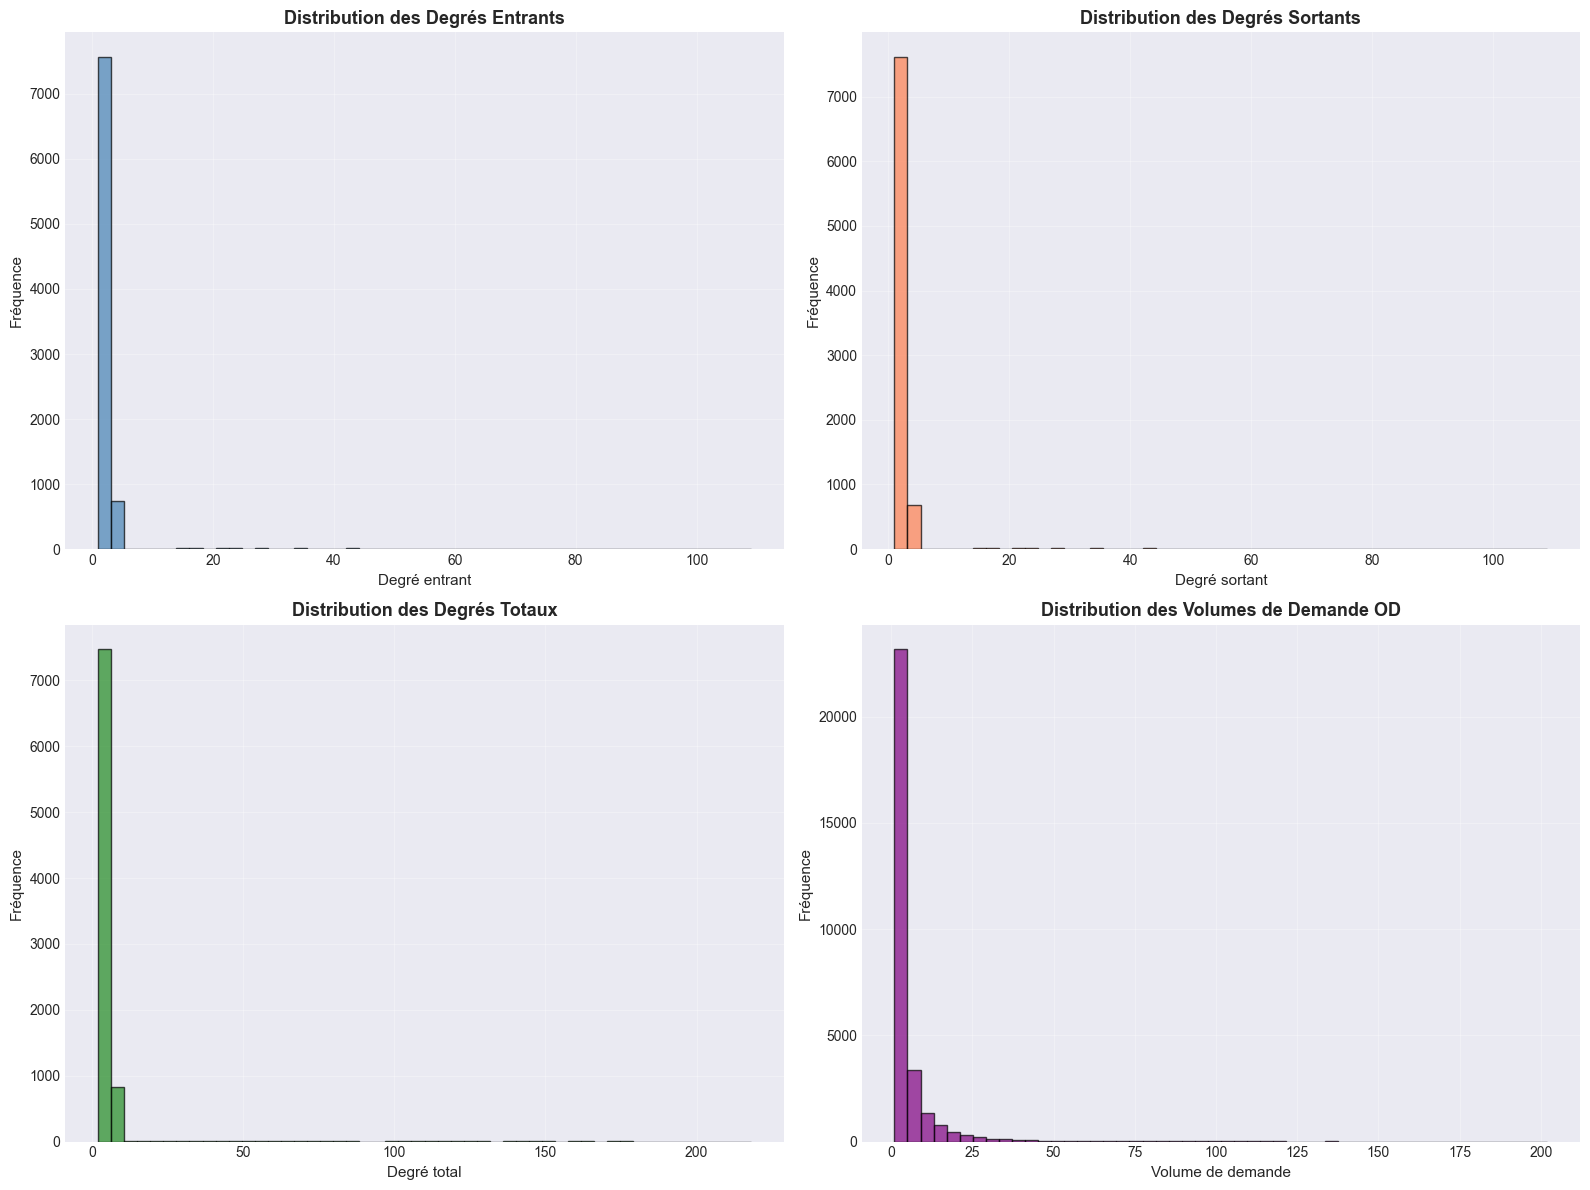

In [18]:
# Visualisation de la distribution des degrés
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogramme des degrés entrants
axes[0, 0].hist(list(in_degree.values()), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Degré entrant', fontsize=11)
axes[0, 0].set_ylabel('Fréquence', fontsize=11)
axes[0, 0].set_title('Distribution des Degrés Entrants', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Histogramme des degrés sortants
axes[0, 1].hist(list(out_degree.values()), bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Degré sortant', fontsize=11)
axes[0, 1].set_ylabel('Fréquence', fontsize=11)
axes[0, 1].set_title('Distribution des Degrés Sortants', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Histogramme des degrés totaux
axes[1, 0].hist(list(total_degree.values()), bins=50, color='forestgreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Degré total', fontsize=11)
axes[1, 0].set_ylabel('Fréquence', fontsize=11)
axes[1, 0].set_title('Distribution des Degrés Totaux', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Distribution de la demande
axes[1, 1].hist(demand_df['volume'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Volume de demande', fontsize=11)
axes[1, 1].set_ylabel('Fréquence', fontsize=11)
axes[1, 1].set_title('Distribution des Volumes de Demande OD', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

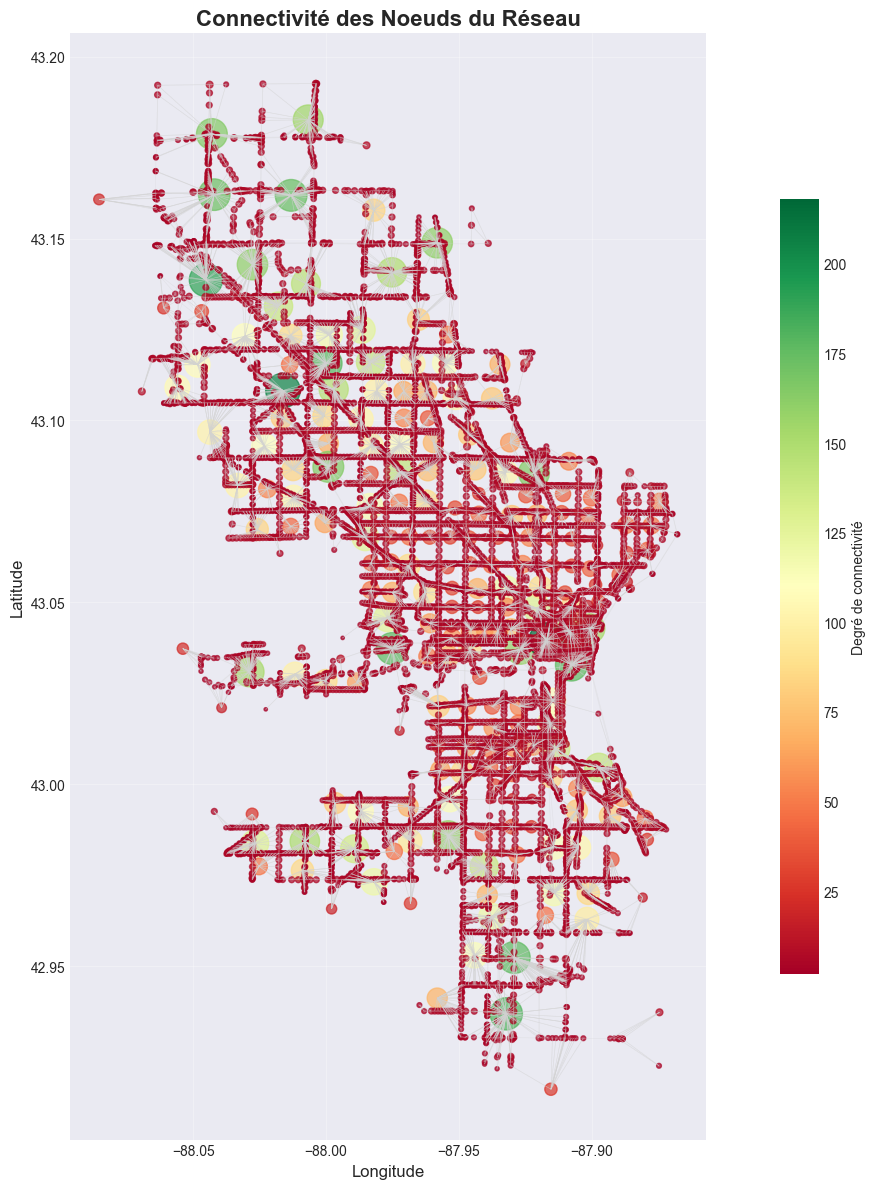


TOP 10 NOEUDS LES PLUS CONNECTÉS
 node_id  zone_id  total_degree    x_coord   y_coord
      67     67.0           218 -87.917036 43.039480
     204    204.0           206 -88.016217 43.108229
     229    229.0           190 -88.045191 43.138600
       7      7.0           180 -87.932203 42.936895
     225    225.0           178 -88.000026 43.115671
      49     49.0           176 -87.907695 43.032757
      79     79.0           176 -87.929223 42.952383
     138    138.0           176 -87.975065 43.037306
     143    143.0           174 -88.013132 43.161862
     220    220.0           172 -88.042056 43.162057


In [19]:
# Visualisation des noeuds par degré de connectivité
fig, ax = plt.subplots(figsize=(15, 12))

# Dessiner les liens
links_gdf.plot(ax=ax, color='lightgray', linewidth=0.4, alpha=0.4)

# Dessiner les noeuds colorés par degré total
nodes_gdf.plot(ax=ax, column='total_degree', cmap='RdYlGn', 
               markersize=nodes_gdf['total_degree']*3,
               alpha=0.7, legend=True,
               legend_kwds={'label': 'Degré de connectivité', 'shrink': 0.7})

plt.title('Connectivité des Noeuds du Réseau', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identifier les noeuds les plus connectés
top_nodes = nodes_gdf.nlargest(10, 'total_degree')[['node_id', 'zone_id', 'total_degree', 'x_coord', 'y_coord']]
print("\n" + "=" * 80)
print("TOP 10 NOEUDS LES PLUS CONNECTÉS")
print("=" * 80)
print(top_nodes.to_string(index=False))

In [20]:
# Calculer la centralité de degré (pour un échantillon du réseau)
print("Calcul de la centralité de degré...")

# Prendre un échantillon pour les calculs intensifs
if G.number_of_nodes() > 1000:
    print(f"⚠ Réseau volumineux ({G.number_of_nodes()} noeuds). Calcul sur la plus grande composante...")
    # Obtenir la plus grande composante fortement connectée
    largest_cc = max(nx.strongly_connected_components(G), key=len)
    G_sample = G.subgraph(largest_cc).copy()
else:
    G_sample = G

degree_centrality = nx.degree_centrality(G_sample)
in_degree_centrality = nx.in_degree_centrality(G_sample)
out_degree_centrality = nx.out_degree_centrality(G_sample)

print(f"✓ Centralité calculée pour {len(degree_centrality)} noeuds")
print(f"  - Centralité moyenne: {np.mean(list(degree_centrality.values())):.6f}")
print(f"  - Centralité max: {max(degree_centrality.values()):.6f}")
print(f"  - Centralité min: {min(degree_centrality.values()):.6f}")

Calcul de la centralité de degré...
⚠ Réseau volumineux (8521 noeuds). Calcul sur la plus grande composante...
✓ Centralité calculée pour 8493 noeuds
  - Centralité moyenne: 0.000851
  - Centralité max: 0.025671
  - Centralité min: 0.000236


In [21]:
# Statistiques des liens
print("=" * 80)
print("STATISTIQUES DES LIENS")
print("=" * 80)
print(f"\nLongueur des liens:")
print(links_gdf['length'].describe())

print(f"\nVitesse libre (free_speed):")
print(links_gdf['free_speed'].describe())

print(f"\nNombre de voies (lanes):")
print(links_gdf['lanes'].describe())

print(f"\nCapacité:")
capacity_finite = links_gdf[links_gdf['capacity'] < 99999]['capacity']
print(capacity_finite.describe())

STATISTIQUES DES LIENS

Longueur des liens:
count    30747.000000
mean        52.579838
std        107.224728
min          0.000000
25%          0.000000
50%          0.000000
75%         89.925000
max       2699.120000
Name: length, dtype: float64

Vitesse libre (free_speed):
count    30747.000000
mean        31.770742
std         19.853319
min         15.000000
25%         15.000000
50%         15.000000
75%         45.000000
max         90.000000
Name: free_speed, dtype: float64

Nombre de voies (lanes):
count    30747.000000
mean         1.141510
std          0.407728
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: lanes, dtype: float64

Capacité:
count    14173.000000
mean      1564.778099
std        281.935323
min       1400.000000
25%       1400.000000
50%       1400.000000
75%       2000.000000
max       2200.000000
Name: capacity, dtype: float64


## 8. Analyse des Performances du Réseau et de la Congestion

In [22]:
# Charger les données de performance des liens
print("Chargement des données de performance...")
link_perf_df = pd.read_csv(data_path + 'link_performance.csv')
print(f"✓ Fichier link_performance.csv chargé: {len(link_perf_df)} enregistrements")

# Filtrer les liens avec du volume
link_perf_active = link_perf_df[link_perf_df['volume'] > 0].copy()
print(f"✓ Liens actifs (avec trafic): {len(link_perf_active)}")

# Afficher un aperçu
print("\nAperçu des données de performance:")
print(link_perf_active[['link_id', 'volume', 'travel_time', 'speed_mph', 'link_capacity', 
                         'D', 'VMT', 'VHT']].head(10))

Chargement des données de performance...
✓ Fichier link_performance.csv chargé: 30747 enregistrements
✓ Liens actifs (avec trafic): 12155

Aperçu des données de performance:
    link_id  volume  travel_time  speed_mph  link_capacity      D  VMT  VHT
9        10     6.0          0.0        0.0        99999.0    6.0  0.0  0.0
10       11     5.0          0.0        0.0        99999.0    5.0  0.0  0.0
16       17    45.0          0.0        0.0        99999.0   45.0  0.0  0.0
27       28     1.0          0.0        0.0        99999.0    1.0  0.0  0.0
28       29    42.0          0.0        0.0        99999.0   42.0  0.0  0.0
29       30    12.0          0.0        0.0        99999.0   12.0  0.0  0.0
30       31   417.0          0.0        0.0        99999.0  417.0  0.0  0.0
41       42    52.0          0.0        0.0        99999.0   52.0  0.0  0.0
50       51   518.0          0.0        0.0        99999.0  518.0  0.0  0.0
51       52    25.0          0.0        0.0        99999.0   25.0 

In [23]:
# Calculer les indicateurs de congestion
link_perf_active['vc_ratio'] = link_perf_active['volume'] / link_perf_active['link_capacity'].replace(0, np.inf)
link_perf_active['vc_ratio'] = link_perf_active['vc_ratio'].replace([np.inf, -np.inf], np.nan)
link_perf_active['congestion_level'] = pd.cut(link_perf_active['vc_ratio'], 
                                                bins=[0, 0.5, 0.8, 0.95, 1.2, np.inf],
                                                labels=['Fluide', 'Modéré', 'Chargé', 'Saturé', 'Surchargé'])

# Calculer le retard
link_perf_active['delay'] = link_perf_active['travel_time'] - link_perf_active['vdf_fftt']
link_perf_active['delay_pct'] = (link_perf_active['delay'] / link_perf_active['vdf_fftt'].replace(0, np.inf)) * 100

print("=" * 80)
print("INDICATEURS DE CONGESTION")
print("=" * 80)
print(f"\nDistribution du ratio Volume/Capacité:")
print(link_perf_active['congestion_level'].value_counts())
print(f"\nRetard moyen: {link_perf_active['delay'].mean():.2f} minutes")
print(f"Retard total (VHT): {link_perf_active['VHT'].sum():.2f} heures-véhicule")
print(f"Distance totale parcourue (VMT): {link_perf_active['VMT'].sum():.2f} miles")

INDICATEURS DE CONGESTION

Distribution du ratio Volume/Capacité:
congestion_level
Fluide       10281
Surchargé      746
Modéré         704
Saturé         256
Chargé         168
Name: count, dtype: int64

Retard moyen: 0.01 minutes
Retard total (VHT): 29698.86 heures-véhicule
Distance totale parcourue (VMT): 824041.09 miles


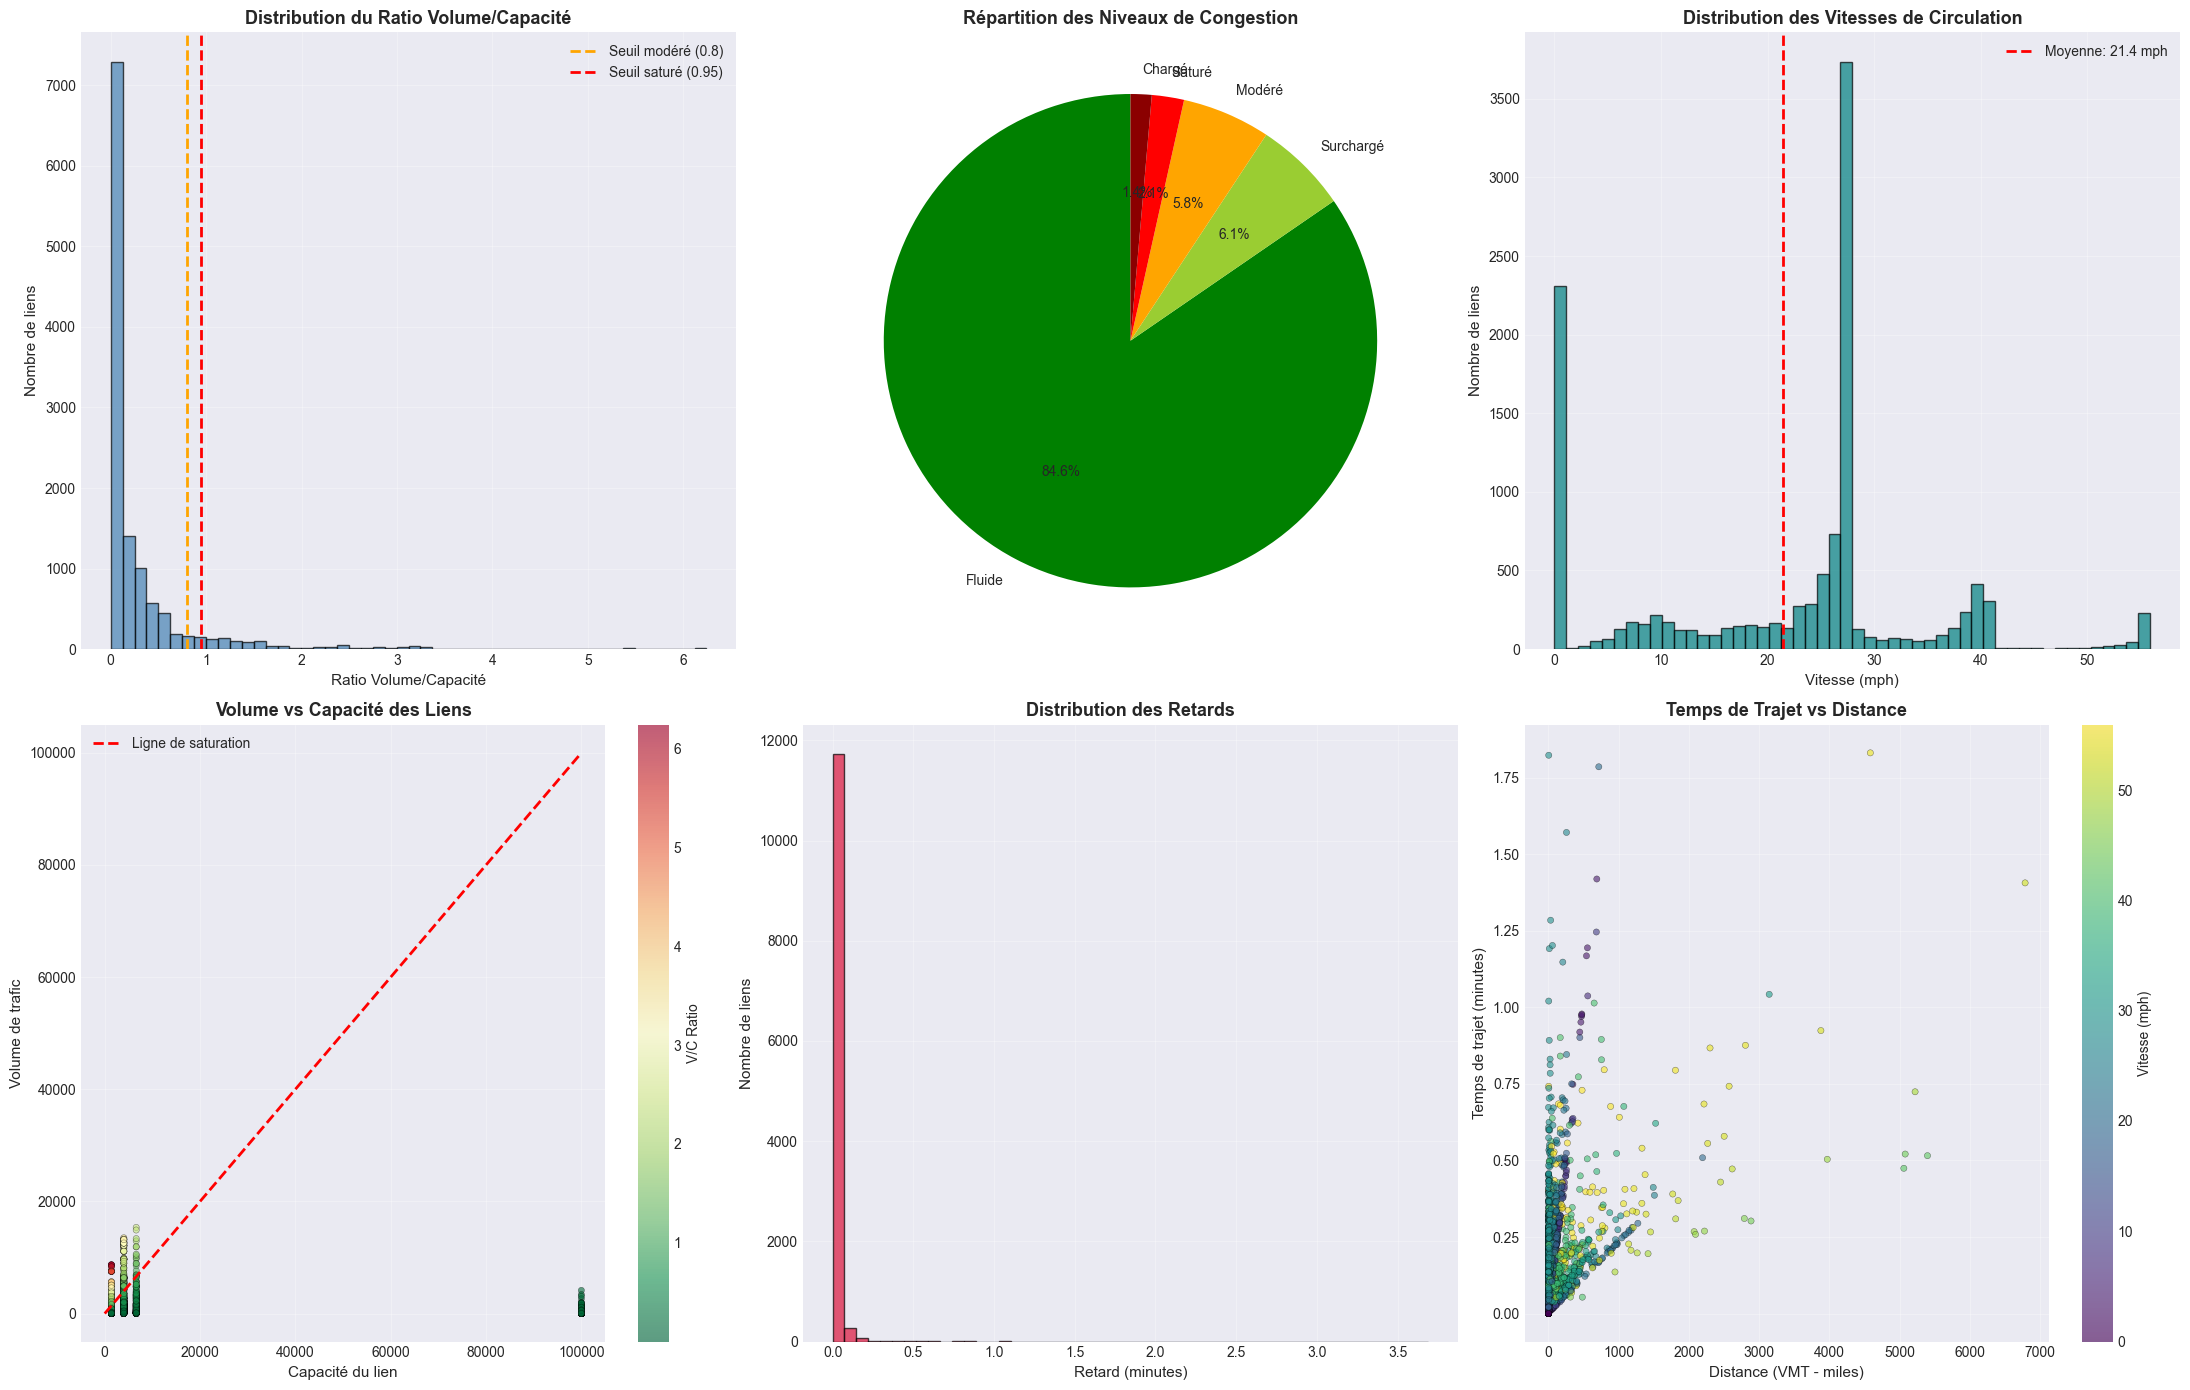

✓ Graphiques de performance affichés


In [24]:
# Visualisations complètes des performances du réseau
fig, axes = plt.subplots(2, 3, figsize=(22, 14))

# 1. Distribution Volume/Capacité
axes[0, 0].hist(link_perf_active['vc_ratio'].dropna(), bins=50, color='steelblue', 
                alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=0.8, color='orange', linestyle='--', linewidth=2, label='Seuil modéré (0.8)')
axes[0, 0].axvline(x=0.95, color='red', linestyle='--', linewidth=2, label='Seuil saturé (0.95)')
axes[0, 0].set_xlabel('Ratio Volume/Capacité', fontsize=11)
axes[0, 0].set_ylabel('Nombre de liens', fontsize=11)
axes[0, 0].set_title('Distribution du Ratio Volume/Capacité', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Niveaux de congestion
congestion_counts = link_perf_active['congestion_level'].value_counts()
colors_cong = ['green', 'yellowgreen', 'orange', 'red', 'darkred']
axes[0, 1].pie(congestion_counts.values, labels=congestion_counts.index, autopct='%1.1f%%',
               colors=colors_cong, startangle=90)
axes[0, 1].set_title('Répartition des Niveaux de Congestion', fontsize=13, fontweight='bold')

# 3. Distribution des vitesses
axes[0, 2].hist(link_perf_active['speed_mph'].dropna(), bins=50, color='teal', 
                alpha=0.7, edgecolor='black')
axes[0, 2].axvline(x=link_perf_active['speed_mph'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Moyenne: {link_perf_active["speed_mph"].mean():.1f} mph')
axes[0, 2].set_xlabel('Vitesse (mph)', fontsize=11)
axes[0, 2].set_ylabel('Nombre de liens', fontsize=11)
axes[0, 2].set_title('Distribution des Vitesses de Circulation', fontsize=13, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Volume vs Capacité (scatter)
sample_perf = link_perf_active.sample(n=min(5000, len(link_perf_active)), random_state=42)
scatter = axes[1, 0].scatter(sample_perf['link_capacity'], sample_perf['volume'], 
                             c=sample_perf['vc_ratio'], cmap='RdYlGn_r', 
                             alpha=0.6, s=20, edgecolors='black', linewidth=0.3)
axes[1, 0].plot([0, sample_perf['link_capacity'].max()], [0, sample_perf['link_capacity'].max()], 
                'r--', linewidth=2, label='Ligne de saturation')
cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('V/C Ratio', fontsize=10)
axes[1, 0].set_xlabel('Capacité du lien', fontsize=11)
axes[1, 0].set_ylabel('Volume de trafic', fontsize=11)
axes[1, 0].set_title('Volume vs Capacité des Liens', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Distribution des retards
axes[1, 1].hist(link_perf_active['delay'].dropna(), bins=50, color='crimson', 
                alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Retard (minutes)', fontsize=11)
axes[1, 1].set_ylabel('Nombre de liens', fontsize=11)
axes[1, 1].set_title('Distribution des Retards', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# 6. Temps de trajet vs Distance
axes[1, 2].scatter(sample_perf['VMT'], sample_perf['travel_time'], 
                   c=sample_perf['speed_mph'], cmap='viridis', 
                   alpha=0.6, s=20, edgecolors='black', linewidth=0.3)
cbar2 = plt.colorbar(axes[1, 2].collections[0], ax=axes[1, 2])
cbar2.set_label('Vitesse (mph)', fontsize=10)
axes[1, 2].set_xlabel('Distance (VMT - miles)', fontsize=11)
axes[1, 2].set_ylabel('Temps de trajet (minutes)', fontsize=11)
axes[1, 2].set_title('Temps de Trajet vs Distance', fontsize=13, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Graphiques de performance affichés")

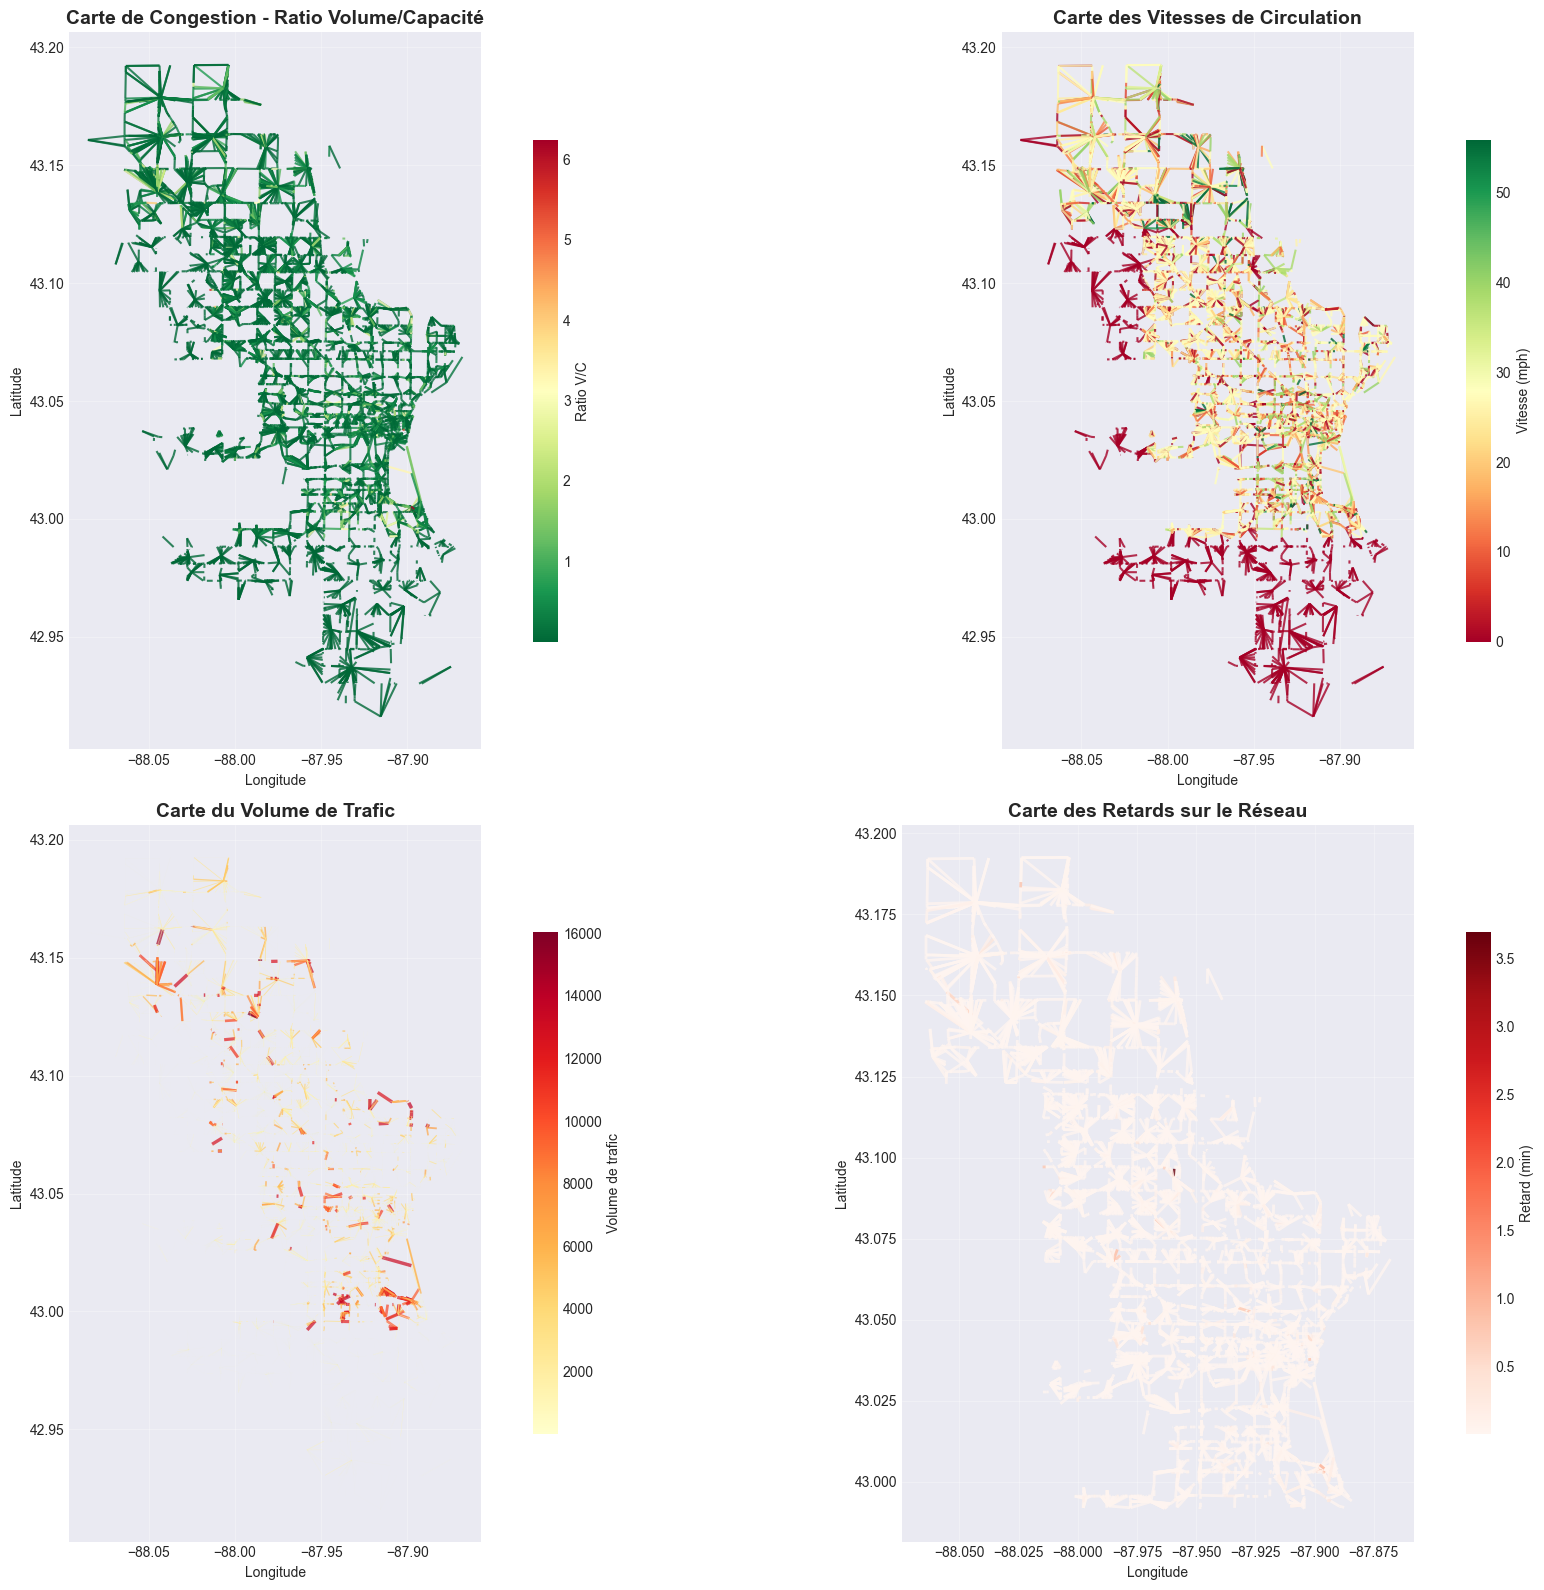

✓ Cartes de congestion affichées pour 30747 liens


In [25]:
# Cartographie de la congestion du réseau
# Fusionner les données de performance avec les liens géographiques
links_with_perf = links_gdf.merge(link_perf_active[['link_id', 'volume', 'vc_ratio', 'speed_mph', 
                                                      'delay', 'congestion_level']], 
                                  on='link_id', how='left')

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Carte 1: Congestion par V/C ratio
links_congested = links_with_perf[links_with_perf['vc_ratio'].notna()]
links_congested.plot(ax=axes[0, 0], column='vc_ratio', cmap='RdYlGn_r', 
                     linewidth=1.5, alpha=0.8, legend=True,
                     legend_kwds={'label': 'Ratio V/C', 'shrink': 0.7})
axes[0, 0].set_title('Carte de Congestion - Ratio Volume/Capacité', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Longitude')
axes[0, 0].set_ylabel('Latitude')
axes[0, 0].grid(True, alpha=0.3)

# Carte 2: Vitesses de circulation
links_with_speed = links_with_perf[links_with_perf['speed_mph'].notna()]
links_with_speed.plot(ax=axes[0, 1], column='speed_mph', cmap='RdYlGn', 
                      linewidth=1.5, alpha=0.8, legend=True,
                      legend_kwds={'label': 'Vitesse (mph)', 'shrink': 0.7})
axes[0, 1].set_title('Carte des Vitesses de Circulation', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_ylabel('Latitude')
axes[0, 1].grid(True, alpha=0.3)

# Carte 3: Volume de trafic
links_with_vol = links_with_perf[links_with_perf['volume'].notna() & (links_with_perf['volume'] > 0)]
links_with_vol.plot(ax=axes[1, 0], column='volume', cmap='YlOrRd', 
                    linewidth=links_with_vol['volume']/links_with_vol['volume'].max()*3, 
                    alpha=0.7, legend=True,
                    legend_kwds={'label': 'Volume de trafic', 'shrink': 0.7})
axes[1, 0].set_title('Carte du Volume de Trafic', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Longitude')
axes[1, 0].set_ylabel('Latitude')
axes[1, 0].grid(True, alpha=0.3)

# Carte 4: Retards
links_with_delay = links_with_perf[links_with_perf['delay'].notna() & (links_with_perf['delay'] > 0)]
links_with_delay.plot(ax=axes[1, 1], column='delay', cmap='Reds', 
                      linewidth=2, alpha=0.8, legend=True,
                      legend_kwds={'label': 'Retard (min)', 'shrink': 0.7})
axes[1, 1].set_title('Carte des Retards sur le Réseau', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Longitude')
axes[1, 1].set_ylabel('Latitude')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Cartes de congestion affichées pour {len(links_with_perf)} liens")

## 9. Analyse des Itinéraires et de l'Affectation du Trafic

In [27]:
# Charger les données d'affectation des itinéraires
print("Chargement des données d'affectation des itinéraires...")
routes_df = pd.read_csv(data_path + 'route_assignment.csv', sep=',')
print(f"✓ Fichier route_assignment.csv chargé: {len(routes_df)} itinéraires")

print("\nAperçu des données d'itinéraires:")
print(routes_df[['route_id', 'o_zone_id', 'd_zone_id', 'distance_mile', 'total_travel_time', 
                  'volume']].head(10))

# Statistiques des itinéraires
print("\n" + "=" * 80)
print("STATISTIQUES DES ITINÉRAIRES")
print("=" * 80)
print(f"Nombre total d'itinéraires: {len(routes_df)}")
print(f"Nombre de paires O-D uniques: {routes_df.groupby(['o_zone_id', 'd_zone_id']).ngroups}")
print(f"\nDistance moyenne: {routes_df['distance_mile'].mean():.2f} miles")
print(f"Temps de trajet moyen: {routes_df['total_travel_time'].mean():.2f} minutes")
print(f"Volume moyen par itinéraire: {routes_df['volume'].mean():.2f}")

Chargement des données d'affectation des itinéraires...
✓ Fichier route_assignment.csv chargé: 29031 itinéraires

Aperçu des données d'itinéraires:
   route_id  o_zone_id  d_zone_id  distance_mile  total_travel_time  volume
0         0          1          2       0.040420           0.175944      12
1         0          1          3       2.826240           6.397580       3
2         0          1          4       0.181658           0.404214       5
3         0          1          5       0.908519           2.011740       1
4         0          1          6       0.998401           2.177330       1
5         0          1          7       4.771910           8.529550      11
6         0          1          8       5.328560           7.234240       1
7         0          1          9       4.440850           5.898050       6
8         0          1         10       4.689880           7.961310       3
9         0          1         12       4.214350           6.794790       1

STATISTIQUES DE

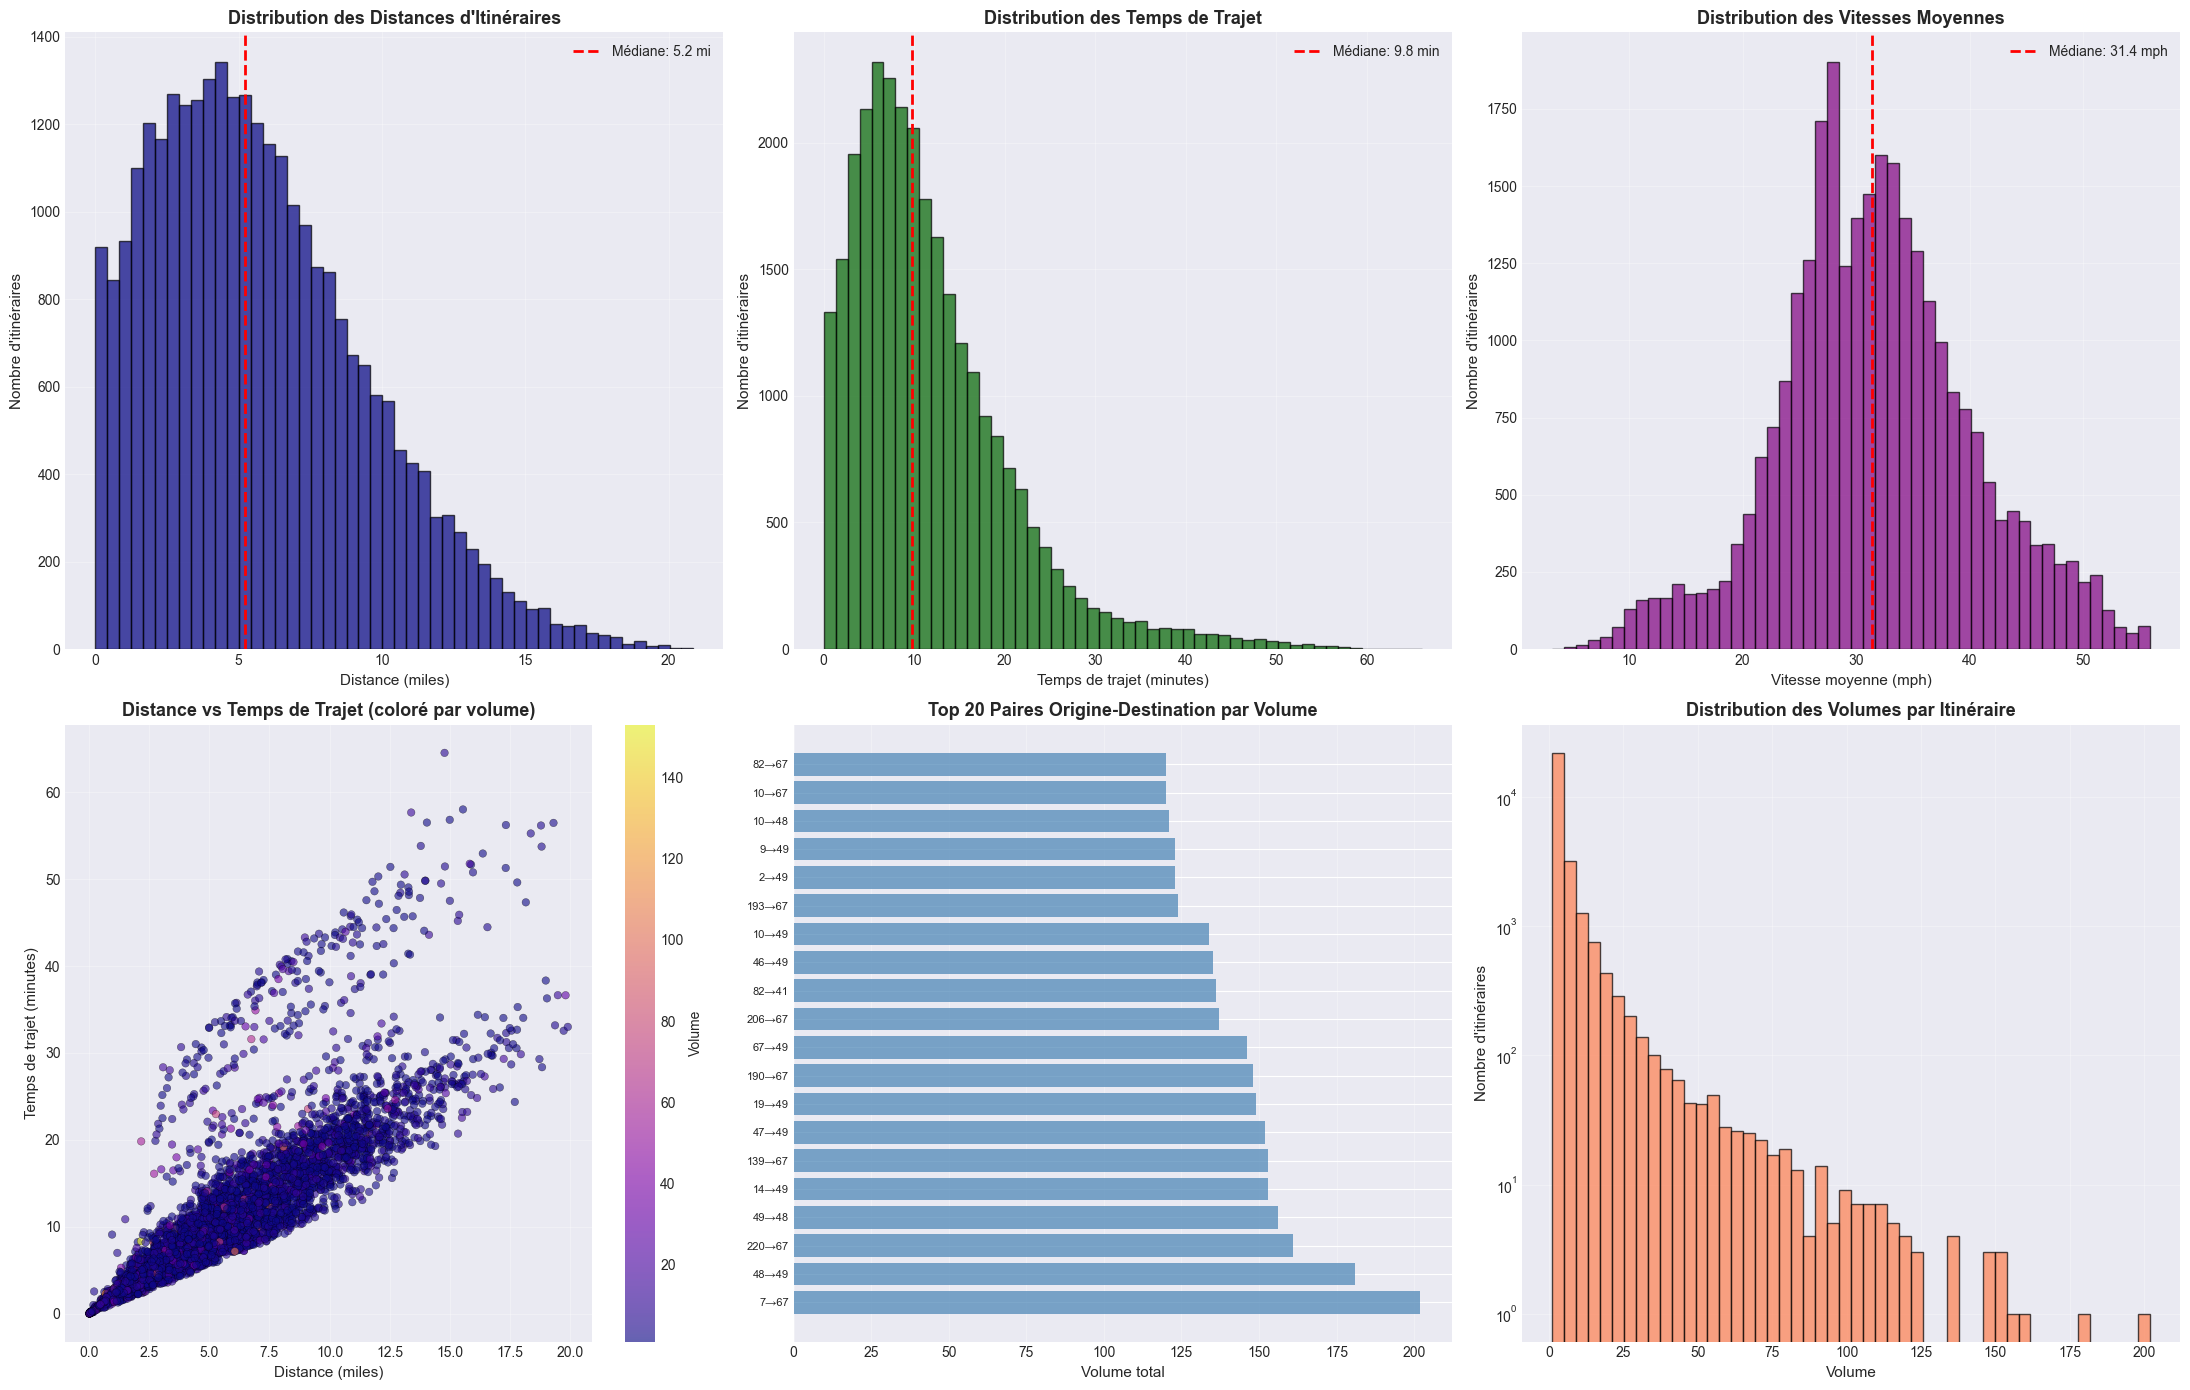

✓ Graphiques d'itinéraires affichés


In [28]:
# Visualisations des itinéraires et de l'affectation
fig, axes = plt.subplots(2, 3, figsize=(22, 14))

# 1. Distribution des distances d'itinéraires
axes[0, 0].hist(routes_df['distance_mile'], bins=50, color='navy', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=routes_df['distance_mile'].median(), color='red', 
                   linestyle='--', linewidth=2, label=f'Médiane: {routes_df["distance_mile"].median():.1f} mi')
axes[0, 0].set_xlabel('Distance (miles)', fontsize=11)
axes[0, 0].set_ylabel('Nombre d\'itinéraires', fontsize=11)
axes[0, 0].set_title('Distribution des Distances d\'Itinéraires', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution des temps de trajet
axes[0, 1].hist(routes_df['total_travel_time'], bins=50, color='darkgreen', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=routes_df['total_travel_time'].median(), color='red', 
                   linestyle='--', linewidth=2, label=f'Médiane: {routes_df["total_travel_time"].median():.1f} min')
axes[0, 1].set_xlabel('Temps de trajet (minutes)', fontsize=11)
axes[0, 1].set_ylabel('Nombre d\'itinéraires', fontsize=11)
axes[0, 1].set_title('Distribution des Temps de Trajet', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Vitesse moyenne par itinéraire
routes_df['avg_speed_mph'] = (routes_df['distance_mile'] / (routes_df['total_travel_time'] / 60)).replace([np.inf, -np.inf], np.nan)
axes[0, 2].hist(routes_df['avg_speed_mph'].dropna(), bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0, 2].axvline(x=routes_df['avg_speed_mph'].median(), color='red', 
                   linestyle='--', linewidth=2, label=f'Médiane: {routes_df["avg_speed_mph"].median():.1f} mph')
axes[0, 2].set_xlabel('Vitesse moyenne (mph)', fontsize=11)
axes[0, 2].set_ylabel('Nombre d\'itinéraires', fontsize=11)
axes[0, 2].set_title('Distribution des Vitesses Moyennes', fontsize=13, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Distance vs Temps de trajet
sample_routes = routes_df.sample(n=min(5000, len(routes_df)), random_state=42)
scatter = axes[1, 0].scatter(sample_routes['distance_mile'], sample_routes['total_travel_time'],
                             c=sample_routes['volume'], cmap='plasma', alpha=0.6, s=30,
                             edgecolors='black', linewidth=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('Volume', fontsize=10)
axes[1, 0].set_xlabel('Distance (miles)', fontsize=11)
axes[1, 0].set_ylabel('Temps de trajet (minutes)', fontsize=11)
axes[1, 0].set_title('Distance vs Temps de Trajet (coloré par volume)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 5. Top 20 paires O-D par volume
od_volume = routes_df.groupby(['o_zone_id', 'd_zone_id'])['volume'].sum().reset_index()
top_od = od_volume.nlargest(20, 'volume')
top_od['od_pair'] = top_od['o_zone_id'].astype(str) + '→' + top_od['d_zone_id'].astype(str)
axes[1, 1].barh(range(len(top_od)), top_od['volume'].values, color='steelblue', alpha=0.7)
axes[1, 1].set_yticks(range(len(top_od)))
axes[1, 1].set_yticklabels(top_od['od_pair'].values, fontsize=8)
axes[1, 1].set_xlabel('Volume total', fontsize=11)
axes[1, 1].set_title('Top 20 Paires Origine-Destination par Volume', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

# 6. Distribution des volumes par itinéraire
axes[1, 2].hist(routes_df['volume'], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1, 2].set_xlabel('Volume', fontsize=11)
axes[1, 2].set_ylabel('Nombre d\'itinéraires', fontsize=11)
axes[1, 2].set_title('Distribution des Volumes par Itinéraire', fontsize=13, fontweight='bold')
axes[1, 2].set_yscale('log')  # Échelle log pour mieux voir la distribution
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Graphiques d'itinéraires affichés")

## 10. Analyse Comparative et Indicateurs Clés de Performance (KPI)

In [29]:
# Calculer les KPI du réseau
print("=" * 80)
print("INDICATEURS CLÉS DE PERFORMANCE (KPI) DU RÉSEAU")
print("=" * 80)

# KPI de capacité et utilisation
total_capacity = links_gdf['capacity'].replace(99999, np.nan).sum()
total_volume = link_perf_active['volume'].sum()
avg_vc_ratio = (total_volume / total_capacity) if total_capacity > 0 else 0

print(f"\n📊 CAPACITÉ ET UTILISATION")
print(f"  - Capacité totale du réseau: {total_capacity:,.0f}")
print(f"  - Volume total de trafic: {total_volume:,.0f}")
print(f"  - Ratio V/C moyen du réseau: {avg_vc_ratio:.3f}")
print(f"  - Taux d'utilisation: {(avg_vc_ratio * 100):.1f}%")

# KPI de performance
total_vmt = link_perf_active['VMT'].sum()
total_vht = link_perf_active['VHT'].sum()
avg_network_speed = (total_vmt / total_vht) if total_vht > 0 else 0

print(f"\n🚗 PERFORMANCE DU RÉSEAU")
print(f"  - Distance totale parcourue (VMT): {total_vmt:,.2f} miles")
print(f"  - Heures-véhicule totales (VHT): {total_vht:,.2f} heures")
print(f"  - Vitesse moyenne du réseau: {avg_network_speed:.2f} mph ({avg_network_speed * 1.60934:.2f} km/h)")

# KPI de congestion
total_delay = link_perf_active['delay'].sum()
pct_congested = (len(link_perf_active[link_perf_active['vc_ratio'] > 0.8]) / len(link_perf_active) * 100)

print(f"\n⚠️ CONGESTION")
print(f"  - Retard total: {total_delay:,.2f} minutes ({total_delay/60:.2f} heures)")
print(f"  - Pourcentage de liens congestionnés (V/C > 0.8): {pct_congested:.1f}%")
print(f"  - Retard moyen par lien: {link_perf_active['delay'].mean():.2f} minutes")

# KPI de demande
total_demand = demand_df['volume'].sum()
total_od_pairs = len(demand_df)

print(f"\n🎯 DEMANDE DE TRANSPORT")
print(f"  - Demande totale: {total_demand:,.0f} déplacements")
print(f"  - Nombre de paires O-D: {total_od_pairs:,}")
print(f"  - Demande moyenne par paire O-D: {demand_df['volume'].mean():.2f}")

# KPI de connectivité
print(f"\n🔗 CONNECTIVITÉ DU RÉSEAU")
print(f"  - Nombre de noeuds: {len(nodes_gdf):,}")
print(f"  - Nombre de liens: {len(links_gdf):,}")
print(f"  - Degré moyen: {np.mean(list(total_degree.values())):.2f}")
print(f"  - Densité du réseau: {nx.density(G):.6f}")

INDICATEURS CLÉS DE PERFORMANCE (KPI) DU RÉSEAU

📊 CAPACITÉ ET UTILISATION
  - Capacité totale du réseau: 22,177,600
  - Volume total de trafic: 9,622,496
  - Ratio V/C moyen du réseau: 0.434
  - Taux d'utilisation: 43.4%

🚗 PERFORMANCE DU RÉSEAU
  - Distance totale parcourue (VMT): 824,041.09 miles
  - Heures-véhicule totales (VHT): 29,698.86 heures
  - Vitesse moyenne du réseau: 27.75 mph (44.65 km/h)

⚠️ CONGESTION
  - Retard total: 151.02 minutes (2.52 heures)
  - Pourcentage de liens congestionnés (V/C > 0.8): 9.6%
  - Retard moyen par lien: 0.01 minutes

🎯 DEMANDE DE TRANSPORT
  - Demande totale: 163,700 déplacements
  - Nombre de paires O-D: 30,422
  - Demande moyenne par paire O-D: 5.38

🔗 CONNECTIVITÉ DU RÉSEAU
  - Nombre de noeuds: 8,521
  - Nombre de liens: 30,747
  - Degré moyen: 7.22
  - Densité du réseau: 0.000424


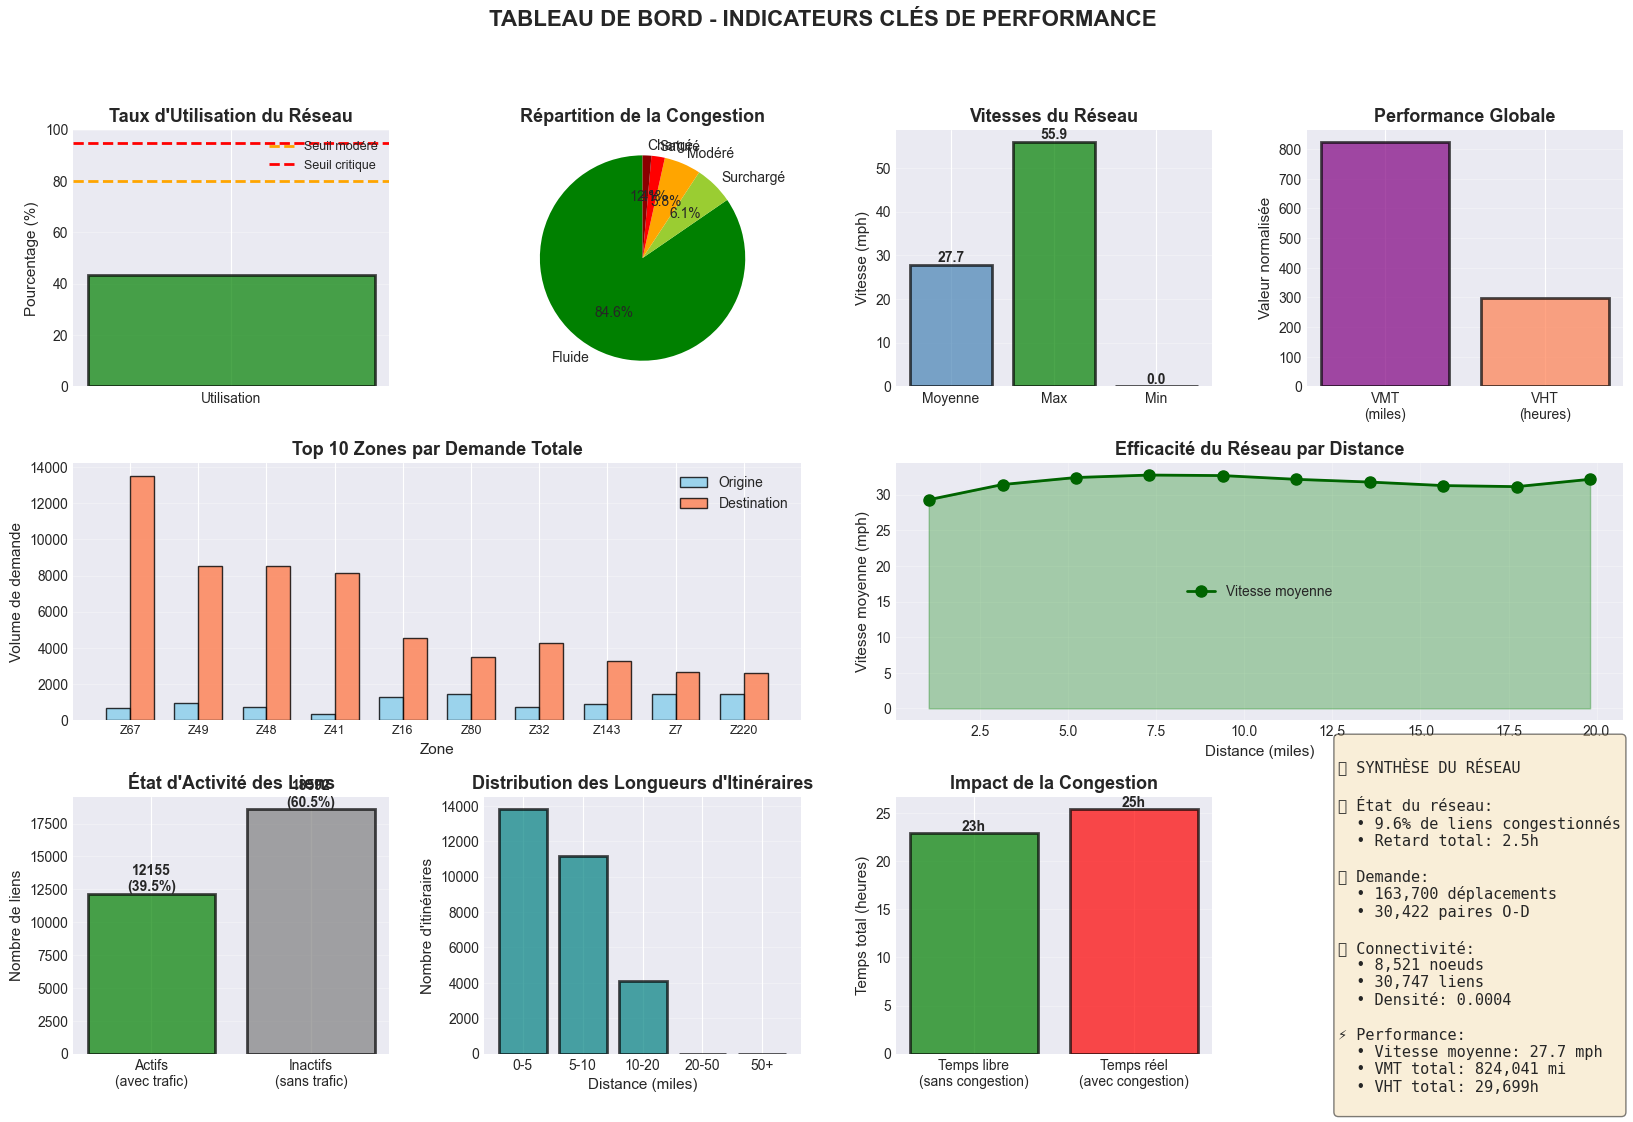

✓ Dashboard KPI affiché


In [30]:
# Dashboard visuel des KPI
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# KPI 1: Taux d'utilisation du réseau
ax1 = fig.add_subplot(gs[0, 0])
colors_util = ['green' if avg_vc_ratio < 0.8 else 'orange' if avg_vc_ratio < 0.95 else 'red']
ax1.bar(['Utilisation'], [avg_vc_ratio * 100], color=colors_util, alpha=0.7, edgecolor='black', linewidth=2)
ax1.axhline(y=80, color='orange', linestyle='--', linewidth=2, label='Seuil modéré')
ax1.axhline(y=95, color='red', linestyle='--', linewidth=2, label='Seuil critique')
ax1.set_ylabel('Pourcentage (%)', fontsize=11)
ax1.set_title('Taux d\'Utilisation du Réseau', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')

# KPI 2: Répartition de la congestion
ax2 = fig.add_subplot(gs[0, 1])
cong_data = link_perf_active['congestion_level'].value_counts()
colors_pie = ['green', 'yellowgreen', 'orange', 'red', 'darkred']
ax2.pie(cong_data.values, labels=cong_data.index, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax2.set_title('Répartition de la Congestion', fontsize=13, fontweight='bold')

# KPI 3: Vitesse moyenne du réseau
ax3 = fig.add_subplot(gs[0, 2])
speeds = [avg_network_speed, link_perf_active['speed_mph'].max(), link_perf_active['speed_mph'].min()]
labels = ['Moyenne', 'Max', 'Min']
bars = ax3.bar(labels, speeds, color=['steelblue', 'green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Vitesse (mph)', fontsize=11)
ax3.set_title('Vitesses du Réseau', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# KPI 4: VMT et VHT
ax4 = fig.add_subplot(gs[0, 3])
metrics = ['VMT\n(miles)', 'VHT\n(heures)']
values = [total_vmt / 1000, total_vht / 100]  # Normalisé pour affichage
ax4.bar(metrics, values, color=['purple', 'coral'], alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_title('Performance Globale', fontsize=13, fontweight='bold')
ax4.set_ylabel('Valeur normalisée', fontsize=11)
ax4.grid(True, alpha=0.3, axis='y')

# KPI 5: Top 10 zones par demande totale (origine + destination)
ax5 = fig.add_subplot(gs[1, :2])
demand_by_origin_kpi = demand_df.groupby('o_zone_id')['volume'].sum()
demand_by_dest_kpi = demand_df.groupby('d_zone_id')['volume'].sum()
total_by_zone = pd.DataFrame({
    'origin': demand_by_origin_kpi,
    'destination': demand_by_dest_kpi
}).fillna(0)
total_by_zone['total'] = total_by_zone['origin'] + total_by_zone['destination']
top_zones = total_by_zone.nlargest(10, 'total')

x = np.arange(len(top_zones))
width = 0.35
ax5.bar(x - width/2, top_zones['origin'], width, label='Origine', color='skyblue', alpha=0.8, edgecolor='black')
ax5.bar(x + width/2, top_zones['destination'], width, label='Destination', color='coral', alpha=0.8, edgecolor='black')
ax5.set_xlabel('Zone', fontsize=11)
ax5.set_ylabel('Volume de demande', fontsize=11)
ax5.set_title('Top 10 Zones par Demande Totale', fontsize=13, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels([f'Z{int(z)}' for z in top_zones.index], fontsize=9)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

# KPI 6: Efficacité du réseau (vitesse vs distance)
ax6 = fig.add_subplot(gs[1, 2:])
distance_bins = pd.cut(routes_df['distance_mile'], bins=10)
efficiency = routes_df.groupby(distance_bins)['avg_speed_mph'].mean()
bin_centers = [interval.mid for interval in efficiency.index]
ax6.plot(bin_centers, efficiency.values, marker='o', linewidth=2, markersize=8, 
         color='darkgreen', label='Vitesse moyenne')
ax6.fill_between(bin_centers, efficiency.values, alpha=0.3, color='green')
ax6.set_xlabel('Distance (miles)', fontsize=11)
ax6.set_ylabel('Vitesse moyenne (mph)', fontsize=11)
ax6.set_title('Efficacité du Réseau par Distance', fontsize=13, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)

# KPI 7: Comparaison liens actifs vs inactifs
ax7 = fig.add_subplot(gs[2, 0])
link_status = ['Actifs\n(avec trafic)', 'Inactifs\n(sans trafic)']
link_counts = [len(link_perf_active), len(links_gdf) - len(link_perf_active)]
colors_status = ['green', 'gray']
ax7.bar(link_status, link_counts, color=colors_status, alpha=0.7, edgecolor='black', linewidth=2)
ax7.set_ylabel('Nombre de liens', fontsize=11)
ax7.set_title('État d\'Activité des Liens', fontsize=13, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(link_counts):
    ax7.text(i, v, f'{v}\n({v/len(links_gdf)*100:.1f}%)', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

# KPI 8: Distribution des longueurs d'itinéraires
ax8 = fig.add_subplot(gs[2, 1])
route_length_bins = ['0-5', '5-10', '10-20', '20-50', '50+']
route_counts = [
    len(routes_df[routes_df['distance_mile'] < 5]),
    len(routes_df[(routes_df['distance_mile'] >= 5) & (routes_df['distance_mile'] < 10)]),
    len(routes_df[(routes_df['distance_mile'] >= 10) & (routes_df['distance_mile'] < 20)]),
    len(routes_df[(routes_df['distance_mile'] >= 20) & (routes_df['distance_mile'] < 50)]),
    len(routes_df[routes_df['distance_mile'] >= 50])
]
ax8.bar(route_length_bins, route_counts, color='teal', alpha=0.7, edgecolor='black', linewidth=2)
ax8.set_xlabel('Distance (miles)', fontsize=11)
ax8.set_ylabel('Nombre d\'itinéraires', fontsize=11)
ax8.set_title('Distribution des Longueurs d\'Itinéraires', fontsize=13, fontweight='bold')
ax8.grid(True, alpha=0.3, axis='y')

# KPI 9: Comparaison temps libre vs temps congestionné
ax9 = fig.add_subplot(gs[2, 2])
total_free_time = link_perf_active['vdf_fftt'].sum()
total_congested_time = link_perf_active['travel_time'].sum()
time_comparison = ['Temps libre\n(sans congestion)', 'Temps réel\n(avec congestion)']
time_values = [total_free_time / 60, total_congested_time / 60]  # Conversion en heures
colors_time = ['green', 'red']
bars = ax9.bar(time_comparison, time_values, color=colors_time, alpha=0.7, edgecolor='black', linewidth=2)
ax9.set_ylabel('Temps total (heures)', fontsize=11)
ax9.set_title('Impact de la Congestion', fontsize=13, fontweight='bold')
ax9.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height, f'{height:.0f}h', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# KPI 10: Synthèse textuelle
ax10 = fig.add_subplot(gs[2, 3])
ax10.axis('off')
summary_text = f"""
📊 SYNTHÈSE DU RÉSEAU

🚦 État du réseau:
  • {pct_congested:.1f}% de liens congestionnés
  • Retard total: {total_delay/60:.1f}h

🎯 Demande:
  • {total_demand:,.0f} déplacements
  • {total_od_pairs:,} paires O-D

🔗 Connectivité:
  • {len(nodes_gdf):,} noeuds
  • {len(links_gdf):,} liens
  • Densité: {nx.density(G):.4f}

⚡ Performance:
  • Vitesse moyenne: {avg_network_speed:.1f} mph
  • VMT total: {total_vmt:,.0f} mi
  • VHT total: {total_vht:,.0f}h
"""
ax10.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
          family='monospace')

plt.suptitle('TABLEAU DE BORD - INDICATEURS CLÉS DE PERFORMANCE', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("✓ Dashboard KPI affiché")